In [5]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import numpy as np

In [6]:
bugün=datetime.now().strftime("%Y-%m-%d")
bugün

'2024-10-14'

In [7]:
dün=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d")

In [8]:
data=pd.read_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/sepet.csv")
data=data.set_index(data["Unnamed: 0"]).drop("Unnamed: 0",axis=1)
data.index.name=""
data=data.drop_duplicates()
try:
    data=data.drop(f"{bugün}",axis=1)
except:
    pass
data

,Ürün,2024-10-11,2024-10-12,2024-10-13
,,,,
Antep Fıstığı,Tadım Antep Fıstığı 180 G,187.95,187.95,187.95
Antep Fıstığı,Siirt Fıstığı Tuzlu Kavrulmuş Kg,899.95,899.95,899.95
Antep Fıstığı,Migros Kavrulmuş Antep Fıstığı 150 G,89.50,89.50,89.50
Antep Fıstığı,Master Nut Kabuklu Antep Fıstığı 140 G,132.95,132.95,132.95
Antep Fıstığı,Emsal Antep Fıstığı 150 G,124.90,124.90,124.90
...,...,...,...,...
Şehriye,Pastavilla Tel Şehriye 500 Gr,27.90,27.90,27.90
Şehriye,Filiz Yıldız Şehriye 500 G,22.75,22.75,22.75
Şehriye,Pastavilla Arpa Şehriye 500g,27.90,27.90,27.90


In [9]:
def veriekle(urun, data, urunler_df):

    if urunler_df is None or urunler_df.empty:
        return data

    elif isinstance(data.loc[urun], pd.Series):
        data_for_urun = data.loc[urun].to_frame().T  # Convert Series to DataFrame
    else:
        data_for_urun = data.loc[urun]

    # Merge the data with urunler_df
    merged_df = pd.merge(data_for_urun, urunler_df, on='Ürün', how='outer')

    # Index'i doğru ürün ismiyle dolduruyoruz
    merged_df.index = len(merged_df) * [urun]

    # Eğer _x ve _y ile aynı tarihli sütunlar varsa birleştiriyoruz
    tarih_sutunlari = [col for col in merged_df.columns if col.endswith("_x") or col.endswith("_y")]
    
    for col in set([col.split("_")[0] for col in tarih_sutunlari]):
        if col + "_x" in merged_df.columns and col + "_y" in merged_df.columns:
            # Sütunları birleştiriyoruz
            merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])
            # _x ve _y sütunlarını kaldırıyoruz
            merged_df = merged_df.drop(columns=[col + "_x", col + "_y"])

    # Eski verileri (urun'e ait olan satırları) çıkarıyoruz
    data_without_urun = data.drop(index=urun)

    # Yeni verileri ekliyoruz
    data = pd.concat([data_without_urun, merged_df])

    # Data'yı index'e göre sıralıyoruz
    data = data.sort_index()

    return data




In [10]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

In [11]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs
def scrape_migros_products(pages):
    product_data = []
    
    for page in pages:
        print(f"Scraping URL: {page}")
        driver.get(page)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get product names and prices
            products = driver.find_elements(By.CSS_SELECTOR, '.product-name')
            prices = driver.find_elements(By.CSS_SELECTOR, '.price-new')

            # Ensure we have matching names and prices
            if len(products) != len(prices):
                print(f"Warning: Number of products and prices do not match on page {page}")

            for i in range(len(products)):
                try:
                    product_name = products[i].text.strip()
                    product_price_text = prices[i].text.strip()
                    product_price = clean_price(product_price_text)  # Convert to float
                    product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                    print(f"Product: {product_name}, Price: {product_price} TRY")
                except Exception as e:
                    print(f"Error scraping product {i} on page: {e}")

        except Exception as e:
            print(f"Error loading products on page: {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/pirinc/c/1134?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]

    
    carrefour_data = []
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = [
    "https://www.migros.com.tr/arama?q=pirin%C3%A7&kategori=5&sirala=indirim-yuzdesine-gore&sayfa=","https://www.migros.com.tr/arama?q=pirin%C3%A7&kategori=5&sirala=indirim-yuzdesine-gore&sayfa=2"
]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Pirinç"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Scraping URL: https://www.migros.com.tr/arama?q=pirin%C3%A7&kategori=5&sirala=indirim-yuzdesine-gore&sayfa=
Product: Tadıbol Baldo Pirinç 2,5 Kg, Price: 199.95 TRY
Product: Tat Yasemin Pirinç 1 Kg, Price: 61.95 TRY
Product: Migros Jasmine Pirinç 1000 G, Price: 44.5 TRY
Product: Migros Baldo Pirinç 1000 G, Price: 67.5 TRY
Product: Anadolu Lezzetleri Sarıköy Gönen Baldo Pirinç 1 Kg, Price: 87.9 TRY
Product: Migros Baldo Pirinç 2500 G, Price: 162.5 TRY
Product: Migros Kırık Pirinç 1000 G, Price: 21.9 TRY
Product: Migros Osmancık Pirinç 2500 G, Price: 117.5 TRY
Product: Migros Osmancık Pirinç 1000 G, Price: 51.95 TRY
Product: Yayla Kırık Pirinç 1 Kg, Price: 31.95 TRY
Product: Ekin Baldo Pirinç 1 Kg, Price: 96.95 TRY
Product: Ekin Osmancık Pirinç 1 Kg, Price: 74.95 TRY
Product: Reis Royal Kepekli Pirinç 500 G, Price: 106.95 TRY
Product: Yayla Tane Tane Pirinç 1 Kg, Price: 65.95 TRY
Product: Reis Arborio Risotto Vakumlu Pirinç 500 G, Price: 123.95 TRY
Product: Yayla Pilavlık Pirinç 1 Kg, Pri

In [12]:
data=veriekle("Pirinç",data,urunler_df)

In [13]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs
def scrape_migros_products(pages):
    product_data = []
    
    for page in pages:
        print(f"Scraping URL: {page}")
        driver.get(page)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get product names and prices
            products = driver.find_elements(By.CSS_SELECTOR, '.product-name')
            prices = driver.find_elements(By.CSS_SELECTOR, '.price-new')

            # Ensure we have matching names and prices
            if len(products) != len(prices):
                print(f"Warning: Number of products and prices do not match on page {page}")

            for i in range(len(products)):
                try:
                    product_name = products[i].text.strip()
                    product_price_text = prices[i].text.strip()
                    product_price = clean_price(product_price_text)  # Convert to float
                    product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                    print(f"Product: {product_name}, Price: {product_price} TRY")
                except Exception as e:
                    print(f"Error scraping product {i} on page : {e}")

        except Exception as e:
            print(f"Error loading products on page : {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=bu%C4%9Fday+unu%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1276"]

    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=bu%C4%9Fday%20unu"]

# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Buğday Unu"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Scraping URL: https://www.migros.com.tr/arama?q=bu%C4%9Fday%20unu
Product: Söke Tam Buğday Unu 1 Kg, Price: 54.95 TRY
Product: Sinangil Tam Buğday Unu 1 Kg, Price: 43.95 TRY
Product: Söke Tam Buğday Unu 2 Kg, Price: 99.95 TRY
Product: Migros Tam Buğday Unu 2 Kg, Price: 61.0 TRY
Product 1: Carrefour Buğday Unu 2 Kg, Price: 37.5 TL
Product 2: Carrefour Buğday Unu 5 Kg, Price: 84.5 TL
Product 3: Carrefour Buğday Unu 1 Kg, Price: 21.0 TL


In [14]:
#data=pd.concat([data,urunler_df],axis=0)

In [15]:

data=veriekle("Buğday Unu",data,urunler_df)

In [16]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros
def scrape_migros_products(base_url, total_pages):
    product_data = []
    
    for page in range(1, total_pages + 1):
        url = f"{base_url}{page}"
        print(f"Scraping page {page}: {url}")
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get product names and prices
            products = driver.find_elements(By.CSS_SELECTOR, '.product-name')
            prices = driver.find_elements(By.CSS_SELECTOR, '.price-new')

            # Ensure we have matching names and prices
            if len(products) != len(prices):
                print(f"Warning: Number of products and prices do not match on page {page}")

            for i in range(len(products)):
                try:
                    product_name = products[i].text.strip()
                    product_price_text = prices[i].text.strip()
                    product_price = clean_price(product_price_text)  # Convert to float
                    product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                    print(f"Product: {product_name}, Price: {product_price} TRY")
                except Exception as e:
                    print(f"Error scraping product {i} on page : {e}")

        except Exception as e:
            print(f"Error loading products on page : {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data


def scrape_carrefour_products():
    carrefour_data=[]
    pages=["https://www.carrefoursa.com/search?q=devam+s%C3%BCt%C3%BC%3AbestSeller%3AproductPrimaryCategoryCode%3A1848&show=All"]
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define base URL and total pages to scrape for Migros
migros_base_url = "https://www.migros.com.tr/arama?q=bebek%20s%C3%BCt%C3%BC&kategori=70507&sirala=akilli-siralama&sayfa="
migros_total_pages = 2

migros_data = scrape_migros_products(migros_base_url, migros_total_pages)


carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)


driver.quit()

urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Bebek Sütü (Toz Karışım)"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Scraping page 1: https://www.migros.com.tr/arama?q=bebek%20s%C3%BCt%C3%BC&kategori=70507&sirala=akilli-siralama&sayfa=1
Product: Bebelac Gold Devam Sütü 3 800 G, Price: 599.95 TRY
Product: Aptamil Prosyneo Bebek Sütü 1 400 G, Price: 459.95 TRY
Product: Hipp 1 Organik Combiotic Bebek Sütü 600 G, Price: 669.95 TRY
Product: Bebelac Gold Devam Sütü 3 800 G + Bebelac Gold 350G, Price: 779.95 TRY
Product: Bebelac Gold Devam Sütü 3 350 G, Price: 299.95 TRY
Product: Hipp 1 Organik Combiotic Bebek Sütü 350 G, Price: 439.95 TRY
Product: Aptamil 1 Bebek Sütü 1200 G 0-6 Ay, Price: 999.95 TRY
Product: SMA İyi Geceler 1 0-6 ay Bebek Sütü 800g, Price: 684.95 TRY
Product: Aptamil 1 Bebek Sütü 350 G 0-6 Ay Akıllı Kutu, Price: 379.95 TRY
Product: Aptamil 1 Bebek Sütü 800 G 0-6 Ay Akıllı Kutu, Price: 729.95 TRY
Product: Aptamil 1 Bebek Sütü İçime Hazır 200 Ml 0-6 Ay, Price: 49.95 TRY
Product: Bebelac Bebek Devam Sütü 1 400 G, Price: 279.95 TRY
Product: Bebelac Gold Bebek Devam Sütü 1 - 800 G, Price: 599.

In [17]:
#data=pd.concat([data,urunler_df],axis=0)

In [18]:
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

In [19]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros
def scrape_migros_products(base_url, total_pages):
    product_data = []
    
    for page in range(1, total_pages + 1):
        url = f"{base_url}{page}"
        print(f"Scraping page {page}: {url}")
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get product names and prices
            products = driver.find_elements(By.CSS_SELECTOR, '.product-name')
            prices = driver.find_elements(By.CSS_SELECTOR, '.price-new')

            # Ensure we have matching names and prices
            if len(products) != len(prices):
                print(f"Warning: Number of products and prices do not match on page {page}")

            for i in range(len(products)):
                try:
                    product_name = products[i].text.strip()
                    product_price_text = prices[i].text.strip()
                    product_price = clean_price(product_price_text)  # Convert to float
                    product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                    print(f"Product: {product_name}, Price: {product_price} TRY")
                except Exception as e:
                    print(f"Error scraping product {i} on page : {e}")

        except Exception as e:
            print(f"Error loading products on page : {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour
def scrape_carrefour_products():
    carrefour_data=[]
    pages = ["https://www.carrefoursa.com/bulgur/c/1142?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define base URL and total pages to scrape for Migros
migros_base_url = "https://www.migros.com.tr/arama?q=bulgur&kategori=1062&sirala=akilli-siralama&sayfa="
migros_total_pages = 2

# Scrape Migros products
migros_data = scrape_migros_products(migros_base_url, migros_total_pages)

# Scrape Carrefour products
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data+carrefour_data
product_df = pd.DataFrame(all_data)


driver.quit()

urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Bulgur"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()




Scraping page 1: https://www.migros.com.tr/arama?q=bulgur&kategori=1062&sirala=akilli-siralama&sayfa=1
Product: Duru Köftelik İnce Bulgur (Çiğköftelik) 1 Kg, Price: 42.95 TRY
Product: Duru Pilavlık Bulgur 1 Kg, Price: 42.95 TRY
Product: Duru Başbaşı Bulgur 1 Kg, Price: 42.95 TRY
Product: Hasata Köftelik Antep Bulguru 1 Kg, Price: 41.95 TRY
Product: Duru Köftelik Bulgur 1 Kg, Price: 42.95 TRY
Product: Migros Köftelik Bulgur 1000 G, Price: 20.95 TRY
Product: Migros Pilavlık Bulgur 2500 G, Price: 51.95 TRY
Product: Migros Pilavlık Bulgur 1000 G, Price: 20.95 TRY
Product: Duru Esmer Çiğ Köftelik Bulgur 1 Kg, Price: 42.95 TRY
Product: Duru Şehriyeli Pilavlık Bulgur 1 Kg, Price: 42.95 TRY
Product: Migros İri Pilavlık Bulgur 1000 G, Price: 26.5 TRY
Product: Yayla Köftelik Bulgur 1 Kg, Price: 39.95 TRY
Product: Duru Kepekli Köftelik Bulgur 1 Kg, Price: 42.95 TRY
Product: Yayla Gurme Siyez Bulgur 500 G, Price: 41.95 TRY
Product: Yayla Pilavlık Bulgur 1 Kg, Price: 39.95 TRY
Product: Tat Tane Bul

In [20]:
#data=pd.concat([data,urunler_df],axis=0)

In [21]:
data=veriekle("Bulgur",data,urunler_df)

In [22]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros
def scrape_migros_products(base_url, total_pages):
    product_data = []
    
    for page in range(1, total_pages + 1):
        url = f"{base_url}{page}"
        print(f"Scraping page {page}: {url}")
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get product names and prices
            products = driver.find_elements(By.CSS_SELECTOR, '.product-name')
            prices = driver.find_elements(By.CSS_SELECTOR, '.price-new')

            # Ensure we have matching names and prices
            if len(products) != len(prices):
                print(f"Warning: Number of products and prices do not match on page {page}")

            for i in range(len(products)):
                try:
                    product_name = products[i].text.strip()
                    product_price_text = prices[i].text.strip()
                    product_price = clean_price(product_price_text)  # Convert to float
                    product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                    print(f"Product: {product_name}, Price: {product_price} TRY")
                except Exception as e:
                    print(f"Error scraping product {i} on page : {e}")

        except Exception as e:
            print(f"Error loading products on page : {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour
def scrape_carrefour_products():
    carrefour_data=[]
    pages = ["https://www.carrefoursa.com/search?q=ekmek%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1398","https://www.carrefoursa.com/search?q=ekmek%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1401"]
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define base URL and total pages to scrape for Migros
migros_base_url = "https://www.migros.com.tr/arama?q=ekmek&kategori=1109&markalar=492&sirala=akilli-siralama&sayfa="
migros_total_pages = 1

# Scrape Migros products
migros_data = scrape_migros_products(migros_base_url, migros_total_pages)

# Scrape Carrefour products
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)


driver.quit()

urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Ekmek"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()



Scraping page 1: https://www.migros.com.tr/arama?q=ekmek&kategori=1109&markalar=492&sirala=akilli-siralama&sayfa=1
Product: Sofra Ekmek Adet, Price: 9.9 TRY
Product: Kepekli Ekmek Adet, Price: 29.9 TRY
Product: Baget Ekmek Sade, Price: 29.9 TRY
Product: Simit Ekmek 120 G (F), Price: 21.95 TRY
Product: Çavdarlı Ekmek 300 G, Price: 34.9 TRY
Product: Susamlı Ekmek 300 G, Price: 29.9 TRY
Product: Tam Buğday Unlu Ekmek Adet, Price: 34.9 TRY
Product: Papatya Ekmek 300 G (Küçük) ( Yeni ), Price: 29.9 TRY
Product: Ekmek Dünyası Favori Açma 70 G, Price: 14.95 TRY
Product: Ekmek Dünyası Favori Kanepe Sandviç 200 G, Price: 27.95 TRY
Product: Ekmek Dünyası Favori Çıtır Susamlı Simit 150 G, Price: 39.95 TRY
Product: Ekmek Dünyası Favori Ayçekirdekli Fırın Kurabiye 200 G, Price: 59.95 TRY
Product: Kanepe Atıştırmalık 200 G, Price: 27.95 TRY
Product: Lavaş 200 G, Price: 34.95 TRY
Product: Minik Sandviç Ekmeği 6'lı, Price: 69.9 TRY
Product: Tost Ekmeği Adet, Price: 49.9 TRY
Product: Alman Ekmeği Adet,

In [23]:
#data=pd.concat([data,urunler_df],axis=0)

In [24]:
data=veriekle("Ekmek",data,urunler_df)

In [25]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

def scrape_migros_products(base_url, total_pages):
    product_data = []
    
    for page in range(1, total_pages + 1):
        url = f"{base_url}{page}"
        print(f"Scraping page {page}: {url}")
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get all product cards
            product_cards = driver.find_elements(By.CSS_SELECTOR, 'sm-list-page-item')

            for product_card in product_cards:
                # Check if the product is sponsored by looking for a specific sponsored class or attribute
                if "external-list-item" in product_card.get_attribute('class').lower():
                    print("Skipping sponsored product.")
                    continue  # Skip this sponsored product

                try:
                    # Extract the product name
                    product_name = product_card.find_element(By.CSS_SELECTOR, '.product-name').text.strip()

                    # Try to extract the price from multiple possible locations
                    price_element = None
                    try:
                        # First attempt using the primary price selector
                        price_element = product_card.find_element(By.CSS_SELECTOR, '.price-new')
                    except Exception:
                        try:
                            # If not found, try another potential selector for the price
                            price_element = product_card.find_element(By.CSS_SELECTOR, '.price .amount')
                        except Exception:
                            print(f"Price not found for product: {product_name}")
                            continue  # Skip if no price is found

                    if price_element:
                        product_price_text = price_element.text.strip()
                        product_price = clean_price(product_price_text)  # Convert price to float
                        # Append product name and price to the list
                        product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"Error scraping a product on page: {e}")

        except Exception as e:
            print(f"Error loading products on page : {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour
def scrape_carrefour_products():
        carrefour_data=[]
        url = "https://www.carrefoursa.com/search?q=bisk%C3%BCvi%3AbestSeller%3AproductPrimaryCategoryCode%3A1529%3AinStockFlag%3Atrue&show=All"

    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
        return carrefour_data

# Define base URL and total pages to scrape for Migros
migros_base_url = "https://www.migros.com.tr/arama?q=bisk%C3%BCvi&kategori=1084&sayfa="
migros_total_pages = 8

# Scrape Migros products
migros_data = scrape_migros_products(migros_base_url, migros_total_pages)

# Scrape Carrefour products
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)


driver.quit()

urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df[urunler_df['Ürün'].str.contains("Bisküvi", case=False)]

urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Bisküvi"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()



Scraping page 1: https://www.migros.com.tr/arama?q=bisk%C3%BCvi&kategori=1084&sayfa=1
Product: Ülker Pötibör Bisküvi 450 G, Price: 49.75 TRY
Product: Eti Kombo Hindistan Cevizi ve Çikolata Kaplamalı Bisküvi 56 g, Price: 17.5 TRY
Skipping sponsored product.
Product: Eti Nero Kakaolu Bisküvi 3 x 110 g, Price: 35.9 TRY
Product: Ülker Pötibör Bisküvi Çifte Kavrulmuş 450 G, Price: 49.75 TRY
Product: Eti Cicibebe Bisküvi 400 G, Price: 57.75 TRY
Product: Eti Burçak Tam Buğday Unlu Bisküvi 3x131 g, Price: 48.0 TRY
Skipping sponsored product.
Product: Eti Kakaolu Bisküvi 125 g, Price: 16.0 TRY
Skipping sponsored product.
Product: Eti Tutku Kakao Kremalı Mozaik Bisküvi 100 g, Price: 17.0 TRY
Product: Eti Cicibebe Bisküvi 172 G, Price: 31.0 TRY
Product: İkram Kremalı Bisküvi Çikolata 252 G, Price: 42.75 TRY
Skipping sponsored product.
Skipping sponsored product.
Product: Eti Puf Kakaolu Bisküvi 18 g, Price: 3.5 TRY
Product: Eti Puf Renkli Bisküvi 18 g, Price: 4.25 TRY
Product: Milka Choco Sensati

In [26]:
#data=pd.concat([data,urunler_df],axis=0)

In [27]:
data=veriekle("Bisküvi",data,urunler_df)

In [28]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs
def scrape_migros_products(pages):
    product_data = []
    
    for url in pages:
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get all product cards
            product_cards = driver.find_elements(By.CSS_SELECTOR, 'sm-list-page-item')

            for product_card in product_cards:
                # Check if the product is sponsored by looking for a specific sponsored class or attribute
                if "external-list-item" in product_card.get_attribute('class').lower():
                    print("Skipping sponsored product.")
                    continue  # Skip this sponsored product

                try:
                    # Extract the product name
                    product_name = product_card.find_element(By.CSS_SELECTOR, '.product-name').text.strip()

                    # Try to extract the price from multiple possible locations
                    price_element = None
                    try:
                        # First attempt using the primary price selector
                        price_element = product_card.find_element(By.CSS_SELECTOR, '.price-new')
                    except Exception:
                        try:
                            # If not found, try another potential selector for the price
                            price_element = product_card.find_element(By.CSS_SELECTOR, '.price .amount')
                        except Exception:
                            print(f"Price not found for product: {product_name}")
                            continue  # Skip if no price is found

                    if price_element:
                        product_price_text = price_element.text.strip()
                        product_price = clean_price(product_price_text)  # Convert price to float
                        # Append product name and price to the list
                        product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"Error scraping a product on page: {e}")

        except Exception as e:
            print(f"Error loading products on page: {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=kraker%3AbestSeller%3AinStockFlag%3Atrue&show=All"]


    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=kraker&sayfa=1&kategori=10218&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=kraker&sayfa=2&kategori=10218&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=kraker&sayfa=3&kategori=10218&sirala=akilli-siralama"]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Kraker"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Product: Eti Crax Çubuk Kraker 85 g, Price: 8.5 TRY
Product: Ülker Tuzlu Çubuk Kraker 40 G, Price: 4.5 TRY
Skipping sponsored product.
Product: Eti Balık Kraker 40 G, Price: 7.0 TRY
Product: Eti Crax Peynirli Çubuk Kraker 80 g, Price: 13.25 TRY
Product: Eti Crax Baharatlı Çubuk Kraker 80 g, Price: 13.25 TRY
Product: Eti Pizza Kraker 38 G, Price: 6.0 TRY
Skipping sponsored product.
Product: Ülker Tuzlu Çubuk Kraker 80 G, Price: 8.5 TRY
Skipping sponsored product.
Product: Eti Susamlı Çubuk Kraker 120 G, Price: 19.0 TRY
Product: Eti Crax Peynirli Çubuk Kraker 175 g, Price: 26.25 TRY
Product: Ülker Badem Kraker Sade 38 G, Price: 6.5 TRY
Skipping sponsored product.
Skipping sponsored product.
Product: Eti Crax Baharatlı Çubuk Kraker 175 g, Price: 26.25 TRY
Product: Greta Mevsim Yeşilliği Çeşnili Kraker 4'lü 120 G, Price: 38.0 TRY
Product: Eti Crax Çubuk Kraker 40 g, Price: 4.5 TRY
Product: Eti Pizza Kraker 76 G, Price: 11.5 TRY
Product: Ülker Susamlı Çubuk Kraker 70 G, Price: 11.5 TRY
Prod

In [29]:
#data=pd.concat([data,urunler_df],axis=0)

In [30]:
data=veriekle("Kraker",data,urunler_df)

In [31]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs


# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=gofret%3AbestSeller%3AinStockFlag%3Atrue&text=gofret#"]


    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=gofret&sayfa=1&kategori=1082&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=gofret&sayfa=2&kategori=1082&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=gofret&sayfa=3&kategori=1082&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=gofret&sayfa=4&kategori=1082&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=gofret&sayfa=5&kategori=1082&sirala=akilli-siralama"]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Gofret"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()






Product: 9 Kat Tat Rulokat Fındıklı Rulo Gofret 170G, Price: 56.0 TRY
Product: Ülker Çikolatalı Gofret 4'lü Paket 144 G, Price: 40.0 TRY
Skipping sponsored product.
Product: Nestle Damak Ala Gofret 30 G, Price: 28.5 TRY
Product: Dido Sütlü Çikolatalı Gofret 35 G, Price: 17.0 TRY
Product: Nestlé Nesquik Sütlü Çikolatalı Gofret 26.7 G, Price: 10.0 TRY
Product: Eti Hoşbeş Fındık Kremalı Gofret 142 g, Price: 35.0 TRY
Skipping sponsored product.
Product: Eti Karam Gurme Bitter Çikolatalı Gofret 50 g, Price: 20.0 TRY
Skipping sponsored product.
Product: Tadelle Gofret 35 G, Price: 12.5 TRY
Product: Ülker Dido Kare Çikolatalı Gofret 55,5G, Price: 26.5 TRY
Product: Nestlé Classic Sütlü Çikolatalı Çıtır Gofret 27 gr, Price: 9.5 TRY
Skipping sponsored product.
Skipping sponsored product.
Product: 9 Kat Tat Fındıklı Gofret 39 G, Price: 8.5 TRY
Product: Eti Sütlü Çikolatalı Gofret 34 g, Price: 10.5 TRY
Product: Ülker 9 Kat Tat Portakallı Gofret 39G, Price: 8.5 TRY
Product: Eti Karam Gurme Bitter Ç

In [32]:
#data=pd.concat([data,urunler_df],axis=0)


In [33]:


data=veriekle("Gofret",data,urunler_df)

In [34]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/pastalar/c/1289?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=pasta&sayfa=1&kategori=1113",
                 "https://www.migros.com.tr/arama?q=pasta&sayfa=1&kategori=1111"]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Pasta"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()








Product: Migros Profiterollü Pasta 580 G, Price: 99.0 TRY
Product: Yaş Pasta No 1, Price: 449.9 TRY
Product: Migros Mozaik Pasta 150 G, Price: 47.5 TRY
Product: Coquette Mozaik Pasta 600 G, Price: 146.5 TRY
Product: Tek Pasta 150 G (Yeni), Price: 79.9 TRY
Product: Coquette San Sebastian Cheesecake Kavanozda 180 G, Price: 90.0 TRY
Product: Minik Ekler Kg, Price: 329.9 TRY
Product: Migros Ekler 240 G, Price: 37.5 TRY
Product: Tuzlu Kuru Pasta Normal Kg, Price: 279.9 TRY
Product: Kuru Pasta Tuzlu Ev Tipi Kg (Yeni), Price: 299.9 TRY
Product 1: Koket Frambuazlı Cheesecake 200 Gr, Price: 57.0 TL
Product 2: Meyveli Pasta 24 Kişilik , Price: 199.0 TL
Product 3: Superfresh 724 Fırından Tereyağlı Kruvasan 360 g, Price: 134.9 TL
Product 4: Superfresh Künefe Şerbetli 200 g, Price: 89.5 TL
Product 5: Jacante Meyveli Pasta, Price: 95.0 TL
Product 6: Koket Limonlu Cheesecake 200 Gr, Price: 57.0 TL
Product 7: Özel Çikolatalı Fıstıklı 46 Kişilik Pasta, Price: 360.0 TL
Product 8: Özel Meyveli Pasta 46 K

In [35]:
#data=pd.concat([data,urunler_df],axis=0)

In [36]:
data=veriekle("Pasta",data,urunler_df)

In [37]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=kek%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=kek&sayfa=1&kategori=1085"]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Kek"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()








Product: Ülker Kekstra Mini Çilekli 150 G, Price: 36.0 TRY
Product: Ülker Kekstra Jölebol Çilekli Jöleli Kek 35 G, Price: 7.25 TRY
Skipping sponsored product.
Product: Kekstra Konfeti Muffin Kek Kakaolu 38 G, Price: 8.5 TRY
Product: Ülker Kekstra Mini Çilekli 510 G, Price: 110.0 TRY
Product: Ülker Kekstra Portakallı 40 G, Price: 8.0 TRY
Product: Ülker 8 Kek Mini Muzlu 162 G, Price: 36.0 TRY
Skipping sponsored product.
Product: Eti Browni Gold Mini Çikolatalı Kek 180 g, Price: 42.0 TRY
Skipping sponsored product.
Product: Eti Topkek Fındıklı Kakaolu Kek 35 g, Price: 7.0 TRY
Product: Eti Browni Intense Mini Çikolatalı Kek 160 g, Price: 68.5 TRY
Product: Eti Browni Intense Çikolatalı Kek 50 g, Price: 18.5 TRY
Skipping sponsored product.
Skipping sponsored product.
Product: Biscolata Pia Kek Frambuazlı 100 G, Price: 47.0 TRY
Product: Eti Popkek Çikolatalı Kek 60 g, Price: 10.0 TRY
Product: Eti Popkek Limonlu Kek 60 g, Price: 10.0 TRY
Product: Ülker 8 Kek Orman Meyveli 55 G, Price: 9.0 TRY


In [38]:
#data=pd.concat([data,urunler_df],axis=0)

In [39]:
data=veriekle("Kek",data,urunler_df)

In [40]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=baklava%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1294"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=baklava&sayfa=1&kategori=126"
]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Baklava"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()









Product: Fıstıklı Baklava Kg, Price: 499.9 TRY
Product: Cevizli Ev Baklavası Kg, Price: 399.9 TRY
Product 1: Cevizli Baklava kg, Price: 199.0 TL
Product 2: Fıstıklı Soğuk Baklava Kg, Price: 360.0 TL
Product 3: Fıstıklı Baklava, Price: 350.0 TL
Product 4: Çikolatalı Baklava kg, Price: 255.0 TL
Product 5: Ev Baklavası, Price: 310.0 TL


In [41]:
#data=pd.concat([data,urunler_df],axis=0)

In [42]:
data=veriekle("Baklava",data,urunler_df)

In [43]:
import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/baliklar/c/1099?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=yufka"
]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)


# Combine both datasets into one DataFrame
all_data = migros_data 
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Ekmek Hamuru (Yufka)"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()









Product: El Açması Yufka Kg, Price: 104.9 TRY
Product: Bereket Üçgen Yufka 25 Yaprak 360 G, Price: 49.95 TRY
Product: Günlük Yufka El Açması 500 G, Price: 54.95 TRY
Product: Dureldo Baklavalık Böreklik Yufka 800 G, Price: 59.95 TRY
Product: Unabella Kare Böreklik Yufka 24 Yaprak 800 G, Price: 171.95 TRY
Product: Bereket Yufka 5 Yaprak 500 G, Price: 74.95 TRY
Product: Unİstanbul 3 Yapraklı Yufka 500 G, Price: 99.95 TRY
Product: Untad Baklavalık & Böreklik Yufka 800 G, Price: 114.5 TRY


In [44]:
#data=pd.concat([data,urunler_df],axis=0)

In [45]:
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

In [46]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/makarna/c/1122?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=makarna&sayfa=1&kategori=10112&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=makarna&sayfa=2&kategori=10112&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=makarna&sayfa=3&kategori=10112&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=makarna&sayfa=4&kategori=10112&sirala=akilli-siralama",
                 "https://www.migros.com.tr/arama?q=makarna&sayfa=5&kategori=10112&sirala=akilli-siralama"
                 
]



# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Şehriye", regex=True)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Makarna"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()










Product: Knorr Çabuk Mac & Cheese Peynirli Makarna 212 G, Price: 65.95 TRY
Product: Pastavilla Kalem Makarna 500 G, Price: 27.95 TRY
Product: Filiz Boncuk Makarna 500 G, Price: 22.75 TRY
Product: Filiz Fiyonk Makarna 500 G, Price: 22.75 TRY
Product: Filiz Spagetti (Çubuk) Makarna 500 G, Price: 22.75 TRY
Product: Pastavilla Kuskus Makarna 500 G, Price: 27.95 TRY
Product: Filiz Kalem Makarna 500 G, Price: 22.75 TRY
Product: Pastavilla Burgu Makarna 500 G, Price: 27.95 TRY
Product: Migros Burgu Makarna 500 G, Price: 10.75 TRY
Product: Filiz Burgu Makarna 500 G, Price: 22.75 TRY
Product: Pastavilla Spaghetti Makarna 500 G, Price: 27.95 TRY
Product: Pastavilla Dirsek Makarna 500 G, Price: 27.95 TRY
Product: Pastavilla Mantı Makarna 500 G, Price: 27.95 TRY
Product: Migros Yüksük Makarna 500 G, Price: 10.75 TRY
Product: Pastavilla Kelebek Makarna 500 G, Price: 27.95 TRY
Product: Mutlu Midye Makarna 500 G, Price: 17.95 TRY
Product: Migros Uzun İnce Makarna 500 G, Price: 10.75 TRY
Product: Mutl

In [47]:
#data=pd.concat([data,urunler_df],axis=0)

In [48]:
data=veriekle("Makarna",data,urunler_df)

In [49]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs


# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=%C5%9Fehriye%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1122"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/arama?q=%C5%9Fehriye&sayfa=1&kategori=5"
]

# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Makarna", regex=True)]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Bulgur", regex=True)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Şehriye"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()










Product: Filiz Arpa Şehriye 500 G, Price: 22.75 TRY
Product: Filiz Tel Şehriye 500 G, Price: 22.75 TRY
Product: Filiz Yıldız Şehriye 500 G, Price: 22.75 TRY
Product: Migros Arpa Şehriye 500 G, Price: 10.75 TRY
Product: Pastavilla İri Arpa Şehriye 500 G, Price: 27.95 TRY
Product: Mutlu Arpa Şehriye 500 G, Price: 17.95 TRY
Product: Mutlu Tel Şehriye 500 G, Price: 17.95 TRY
Product: Pastavilla Tel Şehriye 500 G, Price: 27.95 TRY
Product: Pastavilla Arpa Şehriye 500 G, Price: 27.95 TRY
Product: Migros Tel Şehriye 500 G, Price: 10.75 TRY
Product: Veronelli Arpa Şehriye 500 G, Price: 27.95 TRY
Product: Barilla Arpa Şehriye (Risoni) 500 G, Price: 41.95 TRY
Product: Nuh'un Ankara Tel Şehriye 500 G, Price: 22.75 TRY
Product: Arbella Arpa Şehriye Makarna 500 G, Price: 19.95 TRY
Product: Arbella Plus Glutensiz Arpa Şehriye 400 G, Price: 52.95 TRY
Product: Nuh'un Ankara Arpa Şehriye 500 G, Price: 22.75 TRY
Product: Duru Şehriyeli Pilavlık Bulgur 1 Kg, Price: 42.95 TRY
Product 1: Carrefour Arpa Şeh

In [50]:
#data=pd.concat([data,urunler_df],axis=0)


In [51]:
data=veriekle("Şehriye",data,urunler_df)

In [52]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None

# Function to scrape product names and prices from Migros for multiple URLs


# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/musli-hububat-urunleri/c/1378?q=%3AbestSeller%3Acategory%3A1310%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/kahvaltilik-gevrek-c-422?sayfa=1&sirala=onerilenler",
                 "https://www.migros.com.tr/kahvaltilik-gevrek-c-422?sayfa=2&sirala=onerilenler",
                 "https://www.migros.com.tr/kahvaltilik-gevrek-c-422?sayfa=3&sirala=onerilenler",
                 "https://www.migros.com.tr/kahvaltilik-gevrek-c-422?sayfa=4&sirala=onerilenler"
                 

]


# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Tahıl Gevreği"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()











Product: Eti Lifalif Yulaf Ezmesi 500 G, Price: 47.95 TRY
Product: Eti Lifalif İnce Öğütülmüş Yulaf Ezmesi 350 G, Price: 47.95 TRY
Product: Nestlé Nesfit Çikolatalı Tam Tahıl ve Pirinç Gevreği 400g, Price: 118.95 TRY
Product: Fropie Badem&Vanilya Probiyotik Granola 200 G, Price: 109.95 TRY
Product: Nestle Gold Corn Flakes Tam Tahıl Mıs.gevreği 400G, Price: 92.5 TRY
Product: Migros Granola Yulaflı Kakaolu 250 G, Price: 45.45 TRY
Product: Rıchland Granola Yulaflı Ballı ve Keten Tohumu 330G, Price: 69.95 TRY
Product: Moms Granola Muz Ceviz 360 G, Price: 189.9 TRY
Product: Moms Granola Çilek Chia 360 G, Price: 209.9 TRY
Product: Nesquik Mısır Gevreği 1 Kg, Price: 85.0 TRY
Product: Kellogg's Special K Bitter Çikolatalı Tam Buğday ve Pirinç Gevreği 400 G, Price: 114.95 TRY
Product: Nestle Gold Corn Flakes Kakao Aromalı Mısır Gevreği 310g, Price: 88.45 TRY
Product: Crunch Tam Tahıl Ve Pirinç Gevreği Kutu 280 G, Price: 64.0 TRY
Product: Nestle Gold Corn Flakes Tam Tahıl Mısır Gevreği 200 G, Pr

In [53]:

#data=pd.concat([data,urunler_df],axis=0)

In [54]:
data=veriekle("Tahıl Gevreği",data,urunler_df)

In [55]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/search?q=dana+eti%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1046"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/dana-eti-c-3fa?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/dana-eti-c-3fa?sayfa=2&sirala=onerilenler",
                  "https://www.migros.com.tr/dana-eti-c-3fa?sayfa=3&sirala=onerilenler",

]



# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Dana Eti"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()












Product: Dana Kıymalık Kg, Price: 419.95 TRY
Product: Namet Pişmiş Döner 250 G, Price: 165.95 TRY
Product: Dana Kıymalık Yöresel Kg, Price: 469.95 TRY
Product: Uzman Kasap Izgara Köfte 320 G, Price: 99.95 TRY
Product: Dana Kuzu Kıymalık Kg, Price: 419.95 TRY
Product: Uzman Kasap Tekirdağ Köfte 320 G, Price: 162.95 TRY
Product: Erşan Pişmiş Dana Döner 250 G, Price: 159.95 TRY
Product: Dana But Sotelik Et Yöresel Kg, Price: 549.95 TRY
Product: Dana Antrikot Çiftlik Kg, Price: 899.95 TRY
Product: Dana Haşlamalık Gerdan Kg, Price: 379.95 TRY
Product: Uzman Kasap Klasik Köfte 320 G, Price: 159.95 TRY
Product: Dana İncik, Price: 469.95 TRY
Product: Dana Döş Rulo Kg (Kıyma), Price: 429.95 TRY
Product: Dana Döş Rulo Yöresel Kg (Kıyma), Price: 479.95 TRY
Product: Dana Rostoluk Et Yöresel Kg, Price: 529.95 TRY
Product: Minikler İçin Dana Kıyma, Price: 619.95 TRY
Product: Dana Fırınlık Kaburga Kg, Price: 369.95 TRY
Product: Dana Orta Yağlı Et Yöresel Kg, Price: 489.95 TRY
Product: Dana Pirzola An

In [56]:

#data=pd.concat([data,urunler_df],axis=0)

In [57]:
data=veriekle("Dana Eti",data,urunler_df)

In [58]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/kuzu/c/1054?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/kuzu-eti-c-3fb?sayfa=1"

]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Kuzu Eti"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()













Product: Kuzu Yemeklik Kuşbaşı Kg, Price: 665.95 TRY
Product: Kuzu Külbastı Kg (But Eti, Kemiksiz, Dilimli), Price: 725.95 TRY
Product: Kuzu Gerdan Kg (Kemikli, Dilimli), Price: 419.95 TRY
Product: Kuzu İncik Kg, Price: 581.95 TRY
Product: Kuzu Pirzola Kg, Price: 879.95 TRY
Product: Kuzu Sotelik Et Kg, Price: 784.95 TRY
Product: Kuzu Kuşbaşı Kg, Price: 765.95 TRY
Product: Kuzu Fileto Kg, Price: 599.95 TRY
Product: Kuzu Fırınlık Kol Kg (Kemikli, Bütün Kol), Price: 569.95 TRY
Product: Kuzu Sac Kavurmalık Kg, Price: 625.95 TRY
Product: Kuzu Kol Kg (Kemikli, Bütün Kol), Price: 569.95 TRY
Product: Uzman Kasap Kuzu Lokum Şiş Skinpack, Price: 959.95 TRY
Product: Kuzu Şişlik But Kg (Orta Kemikli, İnciksiz Bütün But), Price: 679.95 TRY
Product: Kuzu Beyti Kg, Price: 699.95 TRY
Product: Kuzu But Kg (Kemikli, Bütün But), Price: 579.95 TRY
Product: Kuzu Yarım Kol Kg (Orta Kemikli, İnciksiz Kol), Price: 669.95 TRY
Product 1: Kuzu Gerdan Kg, Price: 495.9 TL
Product 2: Kuzu Kol Kemiksiz Kg, Price: 68

In [59]:

#data=pd.concat([data,urunler_df],axis=0)

In [60]:
data=veriekle("Kuzu Eti",data,urunler_df)

In [61]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/pilic/c/1061?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/pilic-c-3fe?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/pilic-c-3fe?sayfa=2&sirala=onerilenler",
                  "https://www.migros.com.tr/pilic-c-3fe?sayfa=3&sirala=onerilenler",

]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Tavuk Eti"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()


















Product: Banvit Piliç Bonfile Kg, Price: 195.0 TRY
Product: Banvit Piliç Yaprak Döner 200 G, Price: 89.95 TRY
Product: Banvit Piliç Pirzola Kg, Price: 129.0 TRY
Product: Banvit Piliç Schnitzel 700 G, Price: 119.95 TRY
Product: Banvit Piliç Izgara Tava Kg, Price: 299.95 TRY
Product: Beypiliç Ciğer, Price: 49.95 TRY
Product: Banvit Piliç Nugget 700 G, Price: 97.95 TRY
Product: Bolez Köylüm Poşetli Bütün Piliç Kg, Price: 137.95 TRY
Product: Şenpiliç Piliç Kasap Köfte 300 G, Price: 57.95 TRY
Product: Gedik Büyük Tabaklı Piliç Pirzola Kg, Price: 179.95 TRY
Product: Banvit Piliç Nugget 300 G, Price: 54.95 TRY
Product: Bolez Köylüm But Izgara Kg, Price: 284.95 TRY
Product: Gedik Piliç Salamlı Cordon Bleu 285G, Price: 70.95 TRY
Product: Banvit Piliç Schnitzel 300 G, Price: 65.95 TRY
Product: Lezita Acılı Çıtır Jumbo Fileto 300 G, Price: 106.95 TRY
Product: Gedik Piliç Nugget 600 G, Price: 95.95 TRY
Product: Lezita Tam Tahıllı Çıtır Jumbo Fileto 300 G, Price: 106.95 TRY
Product: Orvital Organik

In [62]:

#data=pd.concat([data,urunler_df],axis=0)

In [63]:
data=veriekle("Tavuk Eti",data,urunler_df)

In [64]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None




# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/sakatat-c-3fd"

]






# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)


# Combine both datasets into one DataFrame
all_data = migros_data 
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Sakatat"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()


















Product: Dana Ciğer Kg, Price: 599.95 TRY
Product: Eral Dana Kokoreç Baharatlı 200 G (Kuşbaşı), Price: 165.95 TRY
Product: Kuzu Paça 4'lü, Price: 99.95 TRY
Product: Gurvita İlikli Kemik Suyu Sade 320 Ml, Price: 132.95 TRY
Product: Gurvita Kuzu İlikli Kemik Suyu 320 Ml, Price: 132.95 TRY
Product: Dana Kuyruk (Pöç) Kg, Price: 399.95 TRY
Product: Dana Yürek Kg, Price: 279.95 TRY
Product: Koç Yumurtası Kg, Price: 88.95 TRY
Product: Kuzu Karaciğer Kg, Price: 765.95 TRY
Product: Hasek Dolmalık Mumbar (Salamura Dana Bağırsak) 200 G, Price: 167.95 TRY
Product: Kuzu İşkembe Kg, Price: 149.95 TRY
Product: Kuzu Yürek Kg, Price: 435.95 TRY
Product: Uzman Kasap Dana Beyin 2'li Paket, Price: 155.95 TRY
Product: Dana Dil Kg, Price: 449.95 TRY
Product: Kuzu Kelle Adet, Price: 199.95 TRY
Product: Gurvita İlikli Kemik Suyu Sebzeli 320 Ml, Price: 132.95 TRY
Product: Gurvita İlikli Kemik Sulu Mercimek Çorbası 660 Ml, Price: 242.95 TRY
Product: Eral Dana Kokoreç (Dilimlenmiş-pişmiş) 200 G, Price: 168.95 TR

In [65]:

#data=pd.concat([data,urunler_df],axis=0)

In [66]:
data=veriekle("Sakatat",data,urunler_df)

In [67]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    pages = ["https://www.carrefoursa.com/sucuk/c/1077?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/sucuk-c-404?sayfa=2&sirala=onerilenler",
                 "https://www.migros.com.tr/sucuk-c-404?sayfa=1&sirala=onerilenler",

]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Sucuk"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()



















Product: Etenfes Tekli Küvet Fermente Sucuk Kg, Price: 669.0 TRY
Product: Polonez Kangal Sucuk 180 G, Price: 185.0 TRY
Product: Pınar Gurme Sucuk 250 G, Price: 335.0 TRY
Product: Pınar Hindi Doyum Sucuk 225 G, Price: 95.9 TRY
Product: Başyazıcı Dana Kangal Sucuk 200 G, Price: 177.0 TRY
Product: Pınar Sucuk Kasap İllaki 300 G, Price: 375.0 TRY
Product: Apikoğlu Kangal Sucuk Vakumlu 210 G, Price: 350.0 TRY
Product: İkbal Izgara Dana Dilimli Sucuk 240 G, Price: 279.0 TRY
Product: Pınar Aç Bitir Isıl İşlem Görmüş Dana Sucuk 75 G, Price: 63.9 TRY
Product: Torku Acılı Kangal Sucuk Kg, Price: 799.0 TRY
Product: Torku Acılı Sucuk Vakum 225 G, Price: 239.0 TRY
Product: Namet Dilimli Isıl İşlem Görmüş Sucuk 200 G, Price: 119.0 TRY
Product: Polonez Parmak Sucuk Kg, Price: 849.0 TRY
Product: Polonez Kangal Sucuk Kg, Price: 849.0 TRY
Product: Özlem Dana Kangal Sucuk 220 G, Price: 215.0 TRY
Product: Namet Kangal Sucuk Acılı Kg, Price: 959.0 TRY
Product: Namet Dana Parmak Sucuk Kg, Price: 959.0 TRY
P

In [68]:

#data=pd.concat([data,urunler_df],axis=0)

In [69]:
data=veriekle("Sucuk",data,urunler_df)

In [70]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/sosis/c/1084?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/sosis-c-405?sayfa=1"


]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salam", regex=True)]
urunler_df.index=len(urunler_df)*["Sosis"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()




















Product: Banvit Jumbo Sosis 330 G, Price: 73.9 TRY
Product: Banvit Piliç Kokteyl Sosis 1000 G, Price: 129.0 TRY
Product: Maret 10'lu Sosis 432 G, Price: 355.0 TRY
Product: Polonez Tütsülenmiş Piliç Jumbo Sosis 320 G, Price: 85.9 TRY
Product: Pınar Hindi Uzun Sosis 430 G, Price: 145.0 TRY
Product: Polonez Dana Frankfurter Sosis Kg, Price: None TRY
Product: Namet Hindi Sosis 7/24 140 G, Price: 55.75 TRY
Product: Pınar Sosis Hot Dog 295 G, Price: 270.0 TRY
Product: Namet Kokteyl Sosis Kg, Price: 499.0 TRY
Product: Pınar Aç Bitir Hindi Kokteyl Sosis 130 G, Price: 43.9 TRY
Product: Maret Hindi Uzun Sosis 5'li 210 G, Price: 54.9 TRY
Product: Keskinoğlu Piliç Kokteyl Sosis 750 G, Price: 145.0 TRY
Product: İkbal Füme Dana Sosis 300 G, Price: 375.0 TRY
Product: Maret Sosis 5'Li 240 G, Price: 240.0 TRY
Product: Pınar Kokteyl Sosis 215 G, Price: 169.0 TRY
Product: Namet Frankfurter Piliç Sosis 300G, Price: 99.0 TRY
Product: Erşan 100 Dana Kokteyl Sosis Kg, Price: 375.0 TRY
Product: Erşan Küvet Ko

In [71]:

#data=pd.concat([data,urunler_df],axis=0)

In [72]:
data=veriekle("Sosis",data,urunler_df)

In [73]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/salam-jambon-ve-fume/c/1092?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/salam-c-112d6?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/salam-c-112d6?sayfa=2&sirala=onerilenler",
         

]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Salam"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





















Product: Namet 7 / 24 Hindi Salam 60 G, Price: 17.6 TRY
Product: Pınar Aç Bitir Hindi Salam Taze Dilimlenmiş 10 Dilim 75 G, Price: 30.9 TRY
Product: Namet 7/24 Dana Macar Salam 60 G, Price: 34.95 TRY
Product: Polonez Macar Salam 90 G, Price: 145.0 TRY
Product: Polonez Fıstıklı Salam 90 G, Price: 145.0 TRY
Product: Banvit Baton Piliç Salam 850 Gr, Price: 81.9 TRY
Product: Pınar Salam Doyum Büfe 700 G, Price: 179.0 TRY
Product: Pınar Aç Bitir Hindi Salam Büyük Dilim 60 G, Price: 26.9 TRY
Product: Pınar Aç Bitir Macar Salam 60 G, Price: 52.5 TRY
Product: Torku Dilimli Fıstıklı Salam 50 G, Price: 43.95 TRY
Product: Pınar Hindi Etli Salam Uzun Kg, Price: 499.0 TRY
Product: Maret Pratik Dana Macar Salam 50 G, Price: 37.9 TRY
Product: Migros Tam Yetti Hindi Parça Etli Salam 60 G, Price: 22.5 TRY
Product: Pınar Fıstıklı Salam Kg, Price: 699.0 TRY
Product: Pınar Salam Aç Bitir Hindi Fıstıklı Salam 50 G, Price: 26.9 TRY
Product: Torku Etli Macar Salam 250G, Price: 189.95 TRY
Product: Keskinoğlu 

In [74]:
#data=pd.concat([data,urunler_df],axis=0)

In [75]:
data=veriekle("Salam",data,urunler_df)

In [76]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/pratik-yemek-c-44f?sayfa=1&90=503&sirala=onerilenler"
]




# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)


# Combine both datasets into one DataFrame
all_data = migros_data 
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Hazır Et Yemekleri"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()






















Product: Gurmepack Izgara Köfte & Fusilli Napolitan 300 G, Price: 232.9 TRY
Product: Gurmepack Köri Soslu Tavuk & Fusilli Makarna 360 G, Price: 183.9 TRY
Product: Gurmepack Barbekü Soslu Tavuk & Fusilli Makarna 360G, Price: 183.9 TRY
Product: Yayla Tavuklu Pilav 200 G, Price: 46.95 TRY
Product: Tada Tavuk Eti Konservesi 2X135 G, Price: 122.95 TRY
Product: Gurmepack Izgara Tavuk & Fırında Sebze 320 G, Price: 183.9 TRY
Product: Tat Etli Nohut 200 G, Price: 79.95 TRY
Product: Tada Etli Nohut 250 G, Price: 79.95 TRY
Product: Tat Etli Kuru Fasulye 200 G, Price: 79.95 TRY
Product: Yayla Sebzeli Tavuk Sote 200 G, Price: 69.95 TRY
Product: Tada Ankara Tava 220 G, Price: 129.95 TRY
Product: Tada Hindili Bulgur Pilavı 200G, Price: 83.95 TRY
Product: Tat Hazır Yemek Etli Nohut 400 G, Price: 103.95 TRY
Product: Tat Etli Kuru Fasulye 400 G, Price: 103.95 TRY
Product: Yayla Etli Kuru Fasulye 250 G, Price: 86.95 TRY
Product: Ant Bahar Hindi Islak Hamburger Köftesi 200 G, Price: 89.95 TRY
Product: Yay

In [77]:

#data=pd.concat([data,urunler_df],axis=0)

In [78]:
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

In [79]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/baliklar/c/1099?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/mevsim-baliklari-c-402?sayfa=1"]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Balık"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





















Product: Çipura 400/600 Kg, Price: 379.95 TRY
Product: Levrek 400/600 Kg, Price: 349.95 TRY
Product: Hamsi Kg (Temizlenmeden Gönderilecektir.), Price: 249.95 TRY
Product: Çipura 600/800 Kg(m), Price: 399.95 TRY
Product: Levrek 600/800 Kg, Price: 399.95 TRY
Product: Tekir Orta Kg 1, Price: 499.95 TRY
Product: Çipura Fileto 90/120 Kg (M), Price: 649.95 TRY
Product: Kaya Levrek Toprak 1000/2000 Kg (M), Price: 399.95 TRY
Product: Türk Somonu Bütün Temizlenmiş Kg (M), Price: 229.95 TRY
Product: Minekop Orta Kg (M), Price: 479.95 TRY
Product: Tavuk Balığı Orta Kg, Price: 499.95 TRY
Product 1: Levrek 400600 g, Price: 259.99 TL
Product 2: Levrek 300400 g, Price: 219.99 TL
Product 3: Çipura 400600 g, Price: 249.99 TL
Product 4: Çipura 300400 g, Price: 239.99 TL
Product 5: Çipura 600800 g, Price: 249.99 TL
Product 6: İthal Norveç Somon Fileto Kg, Price: 599.99 TL
Product 7: Levrek 600800 g, Price: 299.99 TL
Product 8: Levrek 8001000 g, Price: 349.99 TL


In [80]:
#data=pd.concat([data,urunler_df],axis=0)

In [81]:
data=veriekle("Balık",data,urunler_df)

In [82]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/paketli-urunler/c/1068?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/dondurulmus-deniz-urunleri-c-2830?sayfa=1&sirala=onerilenler",
                 "https://www.migros.com.tr/dondurulmus-deniz-urunleri-c-2830?sayfa=2&sirala=onerilenler"



]




# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Konserve Balık"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()























Product: Dardanel Fish Finger 400 G, Price: 139.9 TRY
Product: Balık Dünyası Dondurulmuş Kalamar Tava 115G, Price: 114.95 TRY
Product: Pınar Mezgit Fileto 500 G, Price: 349.95 TRY
Product: Kocaman Halka Kalamar 500 G, Price: 309.95 TRY
Product: Balık Dünyası Dondurulmuş Uskumru Fileto 450 G, Price: 119.95 TRY
Product: Kocaman Deluxe Karides 100/150 %50 Glaze 500 G, Price: 439.95 TRY
Product: Kocaman Et Karides 200/300 500 G, Price: 259.95 TRY
Product: Pınar Fish Finger 240 G, Price: 157.95 TRY
Product: Balık Dünyası Dondurulmuş Midye Tava 150G, Price: 94.95 TRY
Product: Dardanel Kabuklu Midye 300 G, Price: 159.95 TRY
Product: Balık Dünyası Dondurulmuş Jumbo Et Karides 150 G, Price: 189.95 TRY
Product: Balık Dünyası Dondrulmuş Jumbo Karides Cızlama 130G, Price: 289.95 TRY
Product: Kocaman Deniz Ürünleri Salatası 400 G, Price: 394.95 TRY
Product: Balık Dünyası Dondurulmuş Jumbo Karides Tava 150G, Price: 124.95 TRY
Product: Dardanel Kaplanmış Halka Kalamar 300 G, Price: 309.9 TRY
Product:

In [83]:
#data=pd.concat([data,urunler_df],axis=0)

In [84]:
data=veriekle("Konserve Balık",data,urunler_df)

In [85]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/sut/c/1311?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/sut-c-6c?sayfa=1&109=1020&sirala=onerilenler",
                 "https://www.migros.com.tr/sut-c-6c?sayfa=2&109=1020&sirala=onerilenler"




]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})
urunler_df.index=len(urunler_df)*["Süt"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Product: Migros %3 Yağlı Uht Süt 1 L, Price: 29.95 TRY
Product: Pınar Süt 1 L, Price: 45.0 TRY
Product: Migros Yarım Yağlı Uht Süt 1000 Ml, Price: 28.25 TRY
Product: Pınar Denge Laktozsuz Süt 1 L, Price: 49.95 TRY
Product: Migros %3 Yağlı Yüksek Sıcaklıkta Pastörize Süt 1 L, Price: 34.25 TRY
Product: İçim Rahat Laktozsuz Süt 1 L, Price: 42.0 TRY
Product: Migros Yarım Yağlı Laktozsuz Uht Süt 1 L, Price: 34.75 TRY
Product: Torku Süt 4X1 L, Price: 178.75 TRY
Product: Migros %3 Yağlı UHT İçme Sütü 200 Ml, Price: 8.95 TRY
Product: Sek Pastörize Günlük Şişe Süt 1 L, Price: 64.95 TRY
Product: Torku Yarım Yağlı Süt 1 L, Price: 36.95 TRY
Product: Sek Süt 1 L, Price: 39.95 TRY
Product: Sek Yeni Nesil Pastörize Günlük Süt 1 L, Price: 57.95 TRY
Product: Pınar Organik Süt 1 L, Price: 55.95 TRY
Product: Danone Uht Laktozsuz İçme Sütü 1 L, Price: 44.95 TRY
Product: İçim Süt 1 L, Price: 39.95 TRY
Product: Sek Çiftlik Tam Yağlı Pastörize Günlük Süt 1 L, Price: 64.95 TRY
Product: İçim Yarım Yağlı Süt 1 

In [86]:

#data=pd.concat([data,urunler_df],axis=0)

In [87]:
data=veriekle("Süt",data,urunler_df)

In [88]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/yogurt/c/1389?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data
# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/yogurt-c-6e?sayfa=1&sirala=onerilenler",
                 "https://www.migros.com.tr/yogurt-c-6e?sayfa=2&sirala=onerilenler",
                 "https://www.migros.com.tr/yogurt-c-6e?sayfa=3&sirala=onerilenler",
                 "https://www.migros.com.tr/yogurt-c-6e?sayfa=4&sirala=onerilenler"




]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Yoğurt"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()

























Product: Migros Tam Yağlı Homojenize Yoğurt 3000 G, Price: 109.0 TRY
Product: Migros Tam Yağlı Homojenize Yoğurt 1500 G, Price: 49.95 TRY
Product: Sütaş Kaymaksız Yoğurt 1000 G, Price: 48.5 TRY
Product: Eker Kaymaklı Tava Yoğurt 1 Kg, Price: 79.95 TRY
Product: Sütaş Süzme Yoğurt 750 G, Price: 92.5 TRY
Product: Torku Yoğurt Tam Yağlı 2 Kg, Price: 114.95 TRY
Product: Sütaş Tava Yoğurt 1000 G, Price: 76.0 TRY
Product: Sütaş Kaymaksız Yoğurt 600 G, Price: 33.0 TRY
Product: Migros Süzme Yoğurt 900 G, Price: 81.0 TRY
Product: Eker Süzme Yoğurt 500 G, Price: 72.95 TRY
Product: Activia Doğal Probiyotik Sade Yoğurt 4x100 G, Price: 59.5 TRY
Product: Tire Süt Kooperatifi Kaymaklı Yoğurt 1500 G, Price: 134.5 TRY
Product: Activia Doğal Probiyotik Çilekli Yoğurt 4X100 G, Price: 59.5 TRY
Product: Activia Doğal Probiyotik İncir&Ceviz&Tahıl Yoğurt 4X100 G, Price: 59.5 TRY
Product: Eker Bidon Yoğurt 2 Kg, Price: 89.95 TRY
Product: İçim Kaymaksız Yoğurt 2000 G, Price: 96.5 TRY
Product: Activia Doğal Prob

In [89]:

#data=pd.concat([data,urunler_df],axis=0)

In [90]:
data=veriekle("Yoğurt",data,urunler_df)

In [91]:


import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/sutlu-tatli-puding/c/1962?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/geleneksel-sutlu-tatlilar-c-2765?sayfa=1&sirala=onerilenler"
]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Hazır Sütlü Tatlılar"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()


























Product: Kinder Süt Dilimi 4 Adet x 28 gr, Price: 41.95 TRY
Product: Kısmet Kazandibi 400 G, Price: 78.5 TRY
Product: Eti Süt Burger Sütlü Ve Ballı 35 G, Price: 11.5 TRY
Product: Eker Sütlaç 150 G, Price: 29.5 TRY
Product: Milka Sütlü Çikolata Kaplamalı Kek 29 G, Price: 32.95 TRY
Product: Eti Browni Mousse 48 G, Price: 19.0 TRY
Product: Eti Süt Burger Sütlü Kakaolu Krema Dolgulu Ballı Kek 35 g, Price: 11.5 TRY
Product: Eker Sakızlı Muhallebi 150 G, Price: 29.5 TRY
Product: Migros Fırın Sütlaç 200 G, Price: 22.5 TRY
Product: Green Way Şekerli Koyulaştırılmış Süt 350 G, Price: 99.95 TRY
Product: Eker Sütlaç 500G, Price: 53.95 TRY
Product: Eker Kazandibi 150 G, Price: 29.5 TRY
Product: Eker Profiterol 100 G, Price: 29.5 TRY
Product: Eker Tavukgöğsü 150 G, Price: 29.5 TRY
Product: Kinder Pingui 30 gr, Price: 13.5 TRY
Product: Kinder Sütlü Delice 39 g, Price: 22.95 TRY
Product: Kinder Pingui 4 adet x 30 gr, Price: 52.5 TRY
Product: Vegan Milk B.Barfe Çilekli Fındıklı Parfe Tatlı 275 G, Pric

In [92]:
#data=pd.concat([data,urunler_df],axis=0)


In [93]:
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

In [94]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/beyaz-peynir/c/1319?q=%3AbestSeller&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/inek-peyniri-c-2731?sayfa=1",
                  "https://www.migros.com.tr/koyun-peyniri-c-2732?sayfa=1",
                  "https://www.migros.com.tr/suzme-peynir-c-2733?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/suzme-peynir-c-2733?sayfa=2&sirala=onerilenler",
                  "https://www.migros.com.tr/keci-peyniri-c-2735?sayfa=1"
         




]




# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Beyaz Peynir"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()



























Product: Altınkılıç Tam Yağlı Olgunlaştırılmış İnek Peyniri 500 G, Price: 239.9 TRY
Product: Migros İnek Peyniri 600G, Price: 168.75 TRY
Product: Ünal Lüks Klasik İnek Peyniri Kg, Price: 425.0 TRY
Product: Tahsildaroğlu Dilimli Klasik İnek Beyaz Peynir 450 G, Price: 259.95 TRY
Product: Tahsildaroğlu Klasik İnek Beyaz Peyniri 500 G, Price: 259.95 TRY
Product: Tahsildaroğlu Klasik İnek Peyniri Kg, Price: 349.5 TRY
Product: Migros Dilimli İnek Peyniri 600 G, Price: 179.9 TRY
Product: Taciroğlu 3 Dilimli Tam Yağlı Olgunlaştırılmış İnek Peyniri 450 G, Price: 249.95 TRY
Product: Onsüt Tam Yağlı Olgunlaştırılmış Beyaz Peynir 600 G, Price: 159.95 TRY
Product: Altınkılıç 3 Dilim Tam Yağlı Olgunlaştırılmış İnek Peyniri 450 G, Price: 239.9 TRY
Product: Akpınar Tam Yağlı Olgunlaştırılmış Laktozsuz Beyaz Peynir Kg, Price: 319.9 TRY
Product: Ariste 1 Dilim Peynir 50 G, Price: 33.95 TRY
Product: Hasmandıra Klasik İnek Peyniri 300 G, Price: 125.0 TRY
Product: Ünal Dilimli Klasik Beyaz Peynir 450 G, Pr

In [95]:
#data=pd.concat([data,urunler_df],axis=0)

In [96]:
data=veriekle("Beyaz Peynir",data,urunler_df)

In [97]:


import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/kasar-/c/1324?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/kasar-peyniri-c-40d?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/kasar-peyniri-c-40d?sayfa=2&sirala=onerilenler"
         
]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Kaşar Peyniri"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





























Product: Bahçıvan Mozzarella Peyniri Rende 200 G, Price: 114.9 TRY
Product: Bahçıvan Tam Yağlı Taze Kaşar Peyniri 400 G, Price: 186.5 TRY
Product: Bahçıvan Dilimli Tost Peyniri 500 G, Price: 216.95 TRY
Product: Torku Tam Yağlı Taze Kaşar Peyniri 600 G, Price: 259.9 TRY
Product: Onsüt Tam Yağlı Taze Kaşar Peyniri 700 G, Price: 194.95 TRY
Product: Tahsildaroğlu Taze Tam Yağlı Çeçil Peyniri 180 G, Price: 109.95 TRY
Product: Onsüt Dilimli Tam Yağlı Taze Tost Peyniri 500 G, Price: 134.95 TRY
Product: Migros Taze Kaşar Peyniri 400 G, Price: 128.9 TRY
Product: Altınkılıç Gurme Eski Kaşar 250 G, Price: 169.95 TRY
Product: Migros Eski Kaşar Peyniri 350G, Price: 139.9 TRY
Product: İçim Kaşar Peyniri 400 G, Price: 135.95 TRY
Product: Migros Dilimli Kaşar Peyniri 225 G, Price: 91.95 TRY
Product: Onsüt Tam Yağlı Tost Peyniri 500 G, Price: 129.95 TRY
Product: Migros Taze Kaşar Peyniri 700 G, Price: 219.0 TRY
Product: Onsüt Tam Yağlı Taze Kaşar Peyniri 225 G, Price: 64.95 TRY
Product: President Kaşar

In [98]:

#data=pd.concat([data,urunler_df],axis=0)

In [99]:
data=veriekle("Kaşar Peyniri",data,urunler_df)

In [100]:


import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/krem-peynir/c/1336?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/arama?q=krem%20peynir&sayfa=1&kategori=10039&sirala=akilli-siralama",
                  "https://www.migros.com.tr/arama?q=krem%20peynir&sayfa=2&kategori=10039&sirala=akilli-siralama"

         




]





# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Krem Peynir"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()































Product: Migros Krem Peynir 500 G, Price: 67.0 TRY
Product: Torku Krem Peynir 300 G, Price: 82.9 TRY
Product: Pınar Krem Peynir 300 G, Price: 65.95 TRY
Product: İçim Krem Peynir 300 G, Price: 64.9 TRY
Product: Teksüt Krem Peynir 300 G, Price: 61.95 TRY
Product: Bahçıvan Tam Yağlı Krem Peynir 300 G, Price: 69.95 TRY
Product: President Cheddarlı Krem Peynir 270 G, Price: 79.95 TRY
Product: Pınar Krem Peynir Cheddarlı 270 G, Price: 84.95 TRY
Product: La Vache Qui Rit Krem Peynir 270G, Price: 89.0 TRY
Product: La Vache Qui Rit Krem Peynir 500 G, Price: 123.75 TRY
Product: La Vache Qui Rit Sade Krem Peynir 140G, Price: 58.0 TRY
Product: Bahçıvan Labne 200 G, Price: 58.5 TRY
Product: Migros Tam Yağlı Taze Labne Peynir 200 G, Price: 34.35 TRY
Product: İçim Labne Peynir 400 G, Price: 87.0 TRY
Product: Pınar Labne 400 G, Price: 90.0 TRY
Product: Torku Labne 180 G, Price: 49.9 TRY
Product: Pınar Beyaz 180 G, Price: 49.95 TRY
Product: İçim Rahat Laktozsuz Labne 180G, Price: 42.9 TRY
Product: Pına

In [101]:
#data=pd.concat([data,urunler_df],axis=0)


In [102]:
data=veriekle("Krem Peynir",data,urunler_df)

In [103]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/yumurta/c/1349?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =   ["https://www.migros.com.tr/yumurta-c-70"

         




]






# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Yumurta"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Product: Yumurtacım 15'li L Boy Yumurta (63-72 G), Price: 72.5 TRY
Product: Güres M - Orta Boy Yumurta 30'lu ( 53 - 62 G), Price: 125.0 TRY
Product: Tire Organik Yumurta 10'lu M Boy (53-62 G), Price: 99.95 TRY
Product: Naturaköy Gezen 15'li Yumurta M Orta Boy (53-62) G, Price: 114.95 TRY
Product: Flotty Organik 10'lu M Orta Boy Yumurta (53-62 G), Price: 99.95 TRY
Product: Yumurtacım 20'li Xl Yumurta (73 G Ve Üzeri), Price: 129.95 TRY
Product: M Life Organik 10'lu M - Orta Boy Yumurta (53-62 G), Price: 77.9 TRY
Product: Kor Organik 10'lu M Orta Boy Yumurta ( 53-62 ) G, Price: 83.9 TRY
Product: Raya Organik 8'li M Boy Yumurta (53 - 62 G), Price: 79.95 TRY
Product: Naturaköy Selenyum 15'li Yumurta M - Orta Boy 53-62 G, Price: 85.95 TRY
Product: Orvital Organik 10'lu M Orta Boy Yumurta (53-62 G), Price: 104.95 TRY
Product: Gürata Ordu Yumurta Üreticileri Birliği Organik 10'lu M Boy (53-62g), Price: 85.9 TRY
Product: Raya Gezen Tavuk Yumurtası 10'lu M Boy, Price: 75.95 TRY
Product: Naturakö

In [104]:
#data=pd.concat([data,urunler_df],axis=0)


In [105]:
data=veriekle("Yumurta",data,urunler_df)

In [106]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/tereyag/c/1350?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/tereyagi-c-413?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/tereyagi-c-413?sayfa=2&sirala=onerilenler"


         




]







# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Tereyağı (Kahvaltılık)"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()




Product: Migros Tereyağı 1000 G, Price: 299.95 TRY
Product: Migros Tereyağı 250 G, Price: 82.0 TRY
Product: Pınar Tereyağı 400G, Price: 209.95 TRY
Product: Pınar Tereyağı 1 Kg, Price: 475.0 TRY
Product: Sütaş Tereyağı 125 G, Price: 55.95 TRY
Product: Torku Tereyağı 1 Kg, Price: 490.0 TRY
Product: Sütaş Geleneksel Tereyağı 250 G, Price: 113.95 TRY
Product: Migros Tereyağ 500 G, Price: 163.0 TRY
Product: Pınar Tereyağı Folyo 200 G, Price: 99.95 TRY
Product: Sek Tereyağı 1 Kg, Price: 450.0 TRY
Product: Sek Köy Tereyağı 225 G, Price: 112.95 TRY
Product: Karlıdağ Malatya Tereyağı Tuzlu Kg, Price: 440.0 TRY
Product: İçim Tereyağı 1 Kg, Price: 449.9 TRY
Product: Hasmandıra Tereyağı Kg, Price: 484.95 TRY
Product: Pınar Tereyağı 125 G, Price: 68.95 TRY
Product: Polonezköy Tereyağı 400 G, Price: 189.95 TRY
Product: Tire Süt Kooperatifi Pastörize Tereyağı 900 G, Price: 450.0 TRY
Product: Hasmandıra Kova Tereyağ 500 G, Price: 229.95 TRY
Product: İçim Köy Tipi Tereyağı 400 G, Price: 195.0 TRY
Produ

In [107]:

#data=pd.concat([data,urunler_df],axis=0)

In [108]:
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

In [109]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/margarin/c/1351?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/margarin-c-414?sayfa=1"]







# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Margarin"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Product: Sana Paket Margarin Hamurişi 250 G, Price: 33.9 TRY
Product: Sana Paket Margarin Klasik 250 G, Price: 26.0 TRY
Product: Sana Kase Margarin Klasik 500 G, Price: 59.9 TRY
Product: Becel Kase Margarin Tereyağı Keyfi 250 G, Price: 35.0 TRY
Product: Bizim Paket Margarin 6X250 G, Price: 145.5 TRY
Product: Sana Paket Margarin Tereyağı Lezzeti 250 G, Price: 29.9 TRY
Product: Becel Kase Margarin Tereyağı Keyfi 500 G, Price: 66.5 TRY
Product: Teremyağ Paket Margarin 3X250 G, Price: 88.5 TRY
Product: Becel Kase Margarin Zeytinyağlı 500 G, Price: 75.9 TRY
Product: Becel Kase Margarin Zeytinyağlı 250 G, Price: 39.9 TRY
Product: Bizim Paket Margarin 250 G, Price: 26.5 TRY
Product: Sana Paket Margarin Klasik 6X250 G, Price: 139.9 TRY
Product: Sana Kase Margarin Ekmeküstü 500 G, Price: 71.9 TRY
Product: Teremyağ Paket Margarin 250 G, Price: 31.0 TRY
Product: Teremyağ Kase Margarin 250 G, Price: 35.0 TRY
Product: Becel Kase Margarin Klasik 250 G, Price: 35.0 TRY
Product: Becel Kase Margarin Kl

In [110]:
#data=pd.concat([data,urunler_df],axis=0)


In [111]:
data=veriekle("Margarin",data,urunler_df)

In [112]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/zeytinyagi/c/1114?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data
# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/zeytinyagi-c-433?sayfa=1&sirala=onerilenler",
                  "https://www.migros.com.tr/zeytinyagi-c-433?sayfa=2&sirala=onerilenler"


         




]







# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Zeytinyağı"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()





Product: Komili Riviera Zeytinyağı 2 L, Price: 649.95 TRY
Product: Tariş Rıvıera Zeytinyağı 2L, Price: 639.95 TRY
Product: Yudum Egemden Sızma Zeytinyağı Yumuşak Lezzet 2L, Price: 784.95 TRY
Product: İlhan Sarı Organik Sızma Zeytinyağı Erken Hasat 500 Ml, Price: 382.9 TRY
Product: Komili Doğu Bahçeleri Naturel Sızma Zeytinyağı 1 L, Price: 381.9 TRY
Product: Asiltane Erken Hasat Soğuk Sıkım Zeytinyağı 500 Ml, Price: 349.95 TRY
Product: İlhan Sarı Organik Sızma Zeytinyağı Olgun Hasat 500 Ml, Price: 322.9 TRY
Product: Tariş Kuzey Ege Sızma Zeytinyağı 1L, Price: 449.9 TRY
Product: Kristal Riviera Zeytinyağı 2 L, Price: 639.95 TRY
Product: Tariş Güney Ege Sızma Zeytinyağı 1L, Price: 442.9 TRY
Product: Komili Naturel Sızma Zeytinyağı Yumuşak Lezzet 1 L, Price: 429.95 TRY
Product: Yudum Egemden Rıvıera Zeytinyağı 2L, Price: 644.95 TRY
Product: Tariş Rıvıera Zeytinyağı 1L, Price: 336.9 TRY
Product: Orkide Naturel Sızma Zeytinyağı 10x10Ml, Price: 89.9 TRY
Product: Kristal Sızma Zeytinyağı Pet 2

In [113]:

#data=pd.concat([data,urunler_df],axis=0)

In [114]:
data=veriekle("Zeytinyağı",data,urunler_df)

In [115]:

import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/aycicek/c/1112?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/aycicek-yagi-c-42d?sayfa=1"


         




]







# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Ayçiçek Yağı"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()














Product: Migros Ayçiçek Yağı 1 L, Price: 61.5 TRY
Product: Migros Ayçiçek Yağı 2 L, Price: 119.0 TRY
Product: Yudum Ayçiçekyağı 5L (Koşeli Pet), Price: 319.5 TRY
Product: Migros Ayçiçek Yağı 5 L Köşeli Pet, Price: 259.0 TRY
Product: Komili Ayçiçek Yağı 5 L, Price: 269.95 TRY
Product: Komili Ayçiçek Yağı 1 L, Price: 105.95 TRY
Product: Torku Ayçiçek Yağı 5 L Pet, Price: 264.95 TRY
Product: Yudum Ayçiçekyağı 1L, Price: 106.95 TRY
Product: Komili Ayçiçek Yağı 2 L, Price: 183.95 TRY
Product: Yudum Ayçiçekyağı 2L, Price: 184.95 TRY
Product: Emek Ayçiçek Yağı 5 L Köşeli Pet, Price: 279.95 TRY
Product: Abalı Ayçiçek Yağı 1 L, Price: 76.95 TRY
Product: Yudum Zerdeçallı Ayçiçekyağı 1L, Price: 66.0 TRY
Product: Kırlangıç Ayçiçek Yağı 1 L, Price: 77.95 TRY
Product: Orkide Ayçiçek Yağı 2 L, Price: 142.95 TRY
Product: Emek Ayçiçek Yağı 2 L, Price: 139.95 TRY
Product 1: Carrefour Ayçiçek Yağı Pet 5 Lt, Price: 259.0 TL
Product 2: Biryağ Ayçiçek Yağı 5 LT Pet, Price: 279.95 TL
Product 3: Carrefour Ayç

In [116]:
#data=pd.concat([data,urunler_df],axis=0)


In [117]:
data=veriekle("Ayçiçek Yağı",data,urunler_df)

In [118]:



import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

options = Options()
options.headless = False  # Tarayıcı görünür modda çalışacak

# WebDriver'ı başlat
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to clean and convert price text to float
def clean_price(price_text):
    # Remove any non-numeric characters except for commas and dots
    price_text = re.sub(r'[^\d,.]', '', price_text)
    # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
    price_text = price_text.replace(',', '.')
    try:
        return float(price_text)
    except ValueError:
        return None



# Function to scrape product names and prices from Carrefour for multiple URLs
def scrape_carrefour_products():
    
    pages = ["https://www.carrefoursa.com/search?q=portakal%3AbestSeller%3AproductPrimaryCategoryCode%3A1016%3AinStockFlag%3Atrue&text=portakal#"]



    
    carrefour_data = []
    
    for url in pages:
    
            # Send a GET request to fetch the HTML content
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, "html.parser")
            
            # Find all product cards
            product_cards = soup.find_all("div", class_="productCardData")
            
            # Loop through each product card and extract the product name and price
            for index, product_card in enumerate(product_cards):
                # Extract product name
                product_name = product_card.find("input", {"id": "productNamePost"})['value']
                
                # Extract product price (from the input tag with id="productPricePost")
                product_price = product_card.find("input", {"id": "productPricePost"})['value']
                
                # Convert price to float
                try:
                    product_price = float(product_price)
                except ValueError:
                    product_price = None  # Handle cases where the price might not be convertible
                
                # Print product name and price
                print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
    
    return carrefour_data

# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/narenciye-c-3ec?sayfa=1&93=652&sirala=onerilenler"


         




]








# Scrape products from Migros and Carrefour
migros_data = scrape_migros_products(migros_pages)
carrefour_data = scrape_carrefour_products()

# Combine both datasets into one DataFrame
all_data = migros_data + carrefour_data
product_df = pd.DataFrame(all_data)

# Close the browser
driver.quit()





urunler_df = product_df.copy()
urunler_df.columns=["Ürün",str(bugün)]
urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

urunler_df.index=len(urunler_df)*["Portakal"]
urunler_df=urunler_df.drop_duplicates()
urunler_df=urunler_df.dropna()




Product: Portakal Kg, Price: 39.95 TRY
Product: Portakal Sıkma File Kg, Price: 24.95 TRY
Product 1: Valensiya Portakal Kg, Price: 65.9 TL


In [119]:
#data=pd.concat([data,urunler_df],axis=0)

In [120]:
data=veriekle("Portakal",data,urunler_df)

In [121]:
def vericek(carrefour="",migros="",name=""):
    try:  

    # Function to clean and convert price text to float
        def clean_price(price_text):
            # Remove any non-numeric characters except for commas and dots
            price_text = re.sub(r'[^\d,.]', '', price_text)
            # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
            price_text = price_text.replace(',', '.')
            try:
                return float(price_text)
            except ValueError:
                return None



        # Function to scrape product names and prices from Carrefour for multiple URLs
        def scrape_carrefour_products(carrefour):
            
            pages = carrefour



            
            carrefour_data = []
            
            for url in pages:
            
                    # Send a GET request to fetch the HTML content
                response = requests.get(url)

                # Check if the request was successful
                if response.status_code == 200:
                    # Parse the HTML content
                    soup = BeautifulSoup(response.content, "html.parser")
                    
                    # Find all product cards
                    product_cards = soup.find_all("div", class_="productCardData")
                    
                    # Loop through each product card and extract the product name and price
                    for index, product_card in enumerate(product_cards):
                        # Extract product name
                        product_name = product_card.find("input", {"id": "productNamePost"})['value']
                        
                        # Extract product price (from the input tag with id="productPricePost")
                        product_price = product_card.find("input", {"id": "productPricePost"})['value']
                        
                        # Convert price to float
                        try:
                            product_price = float(product_price)
                        except ValueError:
                            product_price = None  # Handle cases where the price might not be convertible
                        
                        # Print product name and price
                        print(f"Product {index + 1}: {product_name}, Price: {product_price} TL")
                        carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})

                else:
                    print(f"Failed to retrieve the page. Status code: {response.status_code}")
            
            return carrefour_data

        # Define the list of pages to scrape from Migros
        migros_pages  = migros







        if migros:
            migros_data = scrape_migros_products(migros)
        if carrefour:
            carrefour_data = scrape_carrefour_products(carrefour)

        if migros and carrefour:

            all_data = migros_data + carrefour_data
        elif migros and not carrefour:
            all_data=migros_data
        else:
            all_data=carrefour_data
        product_df = pd.DataFrame(all_data)

        # Close the browser
        driver.quit()





        urunler_df = product_df.copy()
        urunler_df.columns=["Ürün",str(bugün)]
        urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

        urunler_df.index=len(urunler_df)*[name]
        urunler_df=urunler_df.drop_duplicates()
        urunler_df=urunler_df.dropna()

        return urunler_df
    except:
        pass

        

    




In [122]:
carrefour=["https://www.carrefoursa.com/search?q=%C3%BCz%C3%BCm%3AbestSeller%3AproductPrimaryCategoryCode%3A1017%3AinStockFlag%3Atrue&text=%C3%BCz%C3%BCm#"]
migros=["https://www.migros.com.tr/arama?q=%C3%BCz%C3%BCm&sayfa=1&kategori=101"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Üzüm")


data=veriekle("Üzüm",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=armut%3AbestSeller%3AproductPrimaryCategoryCode%3A1018%3AinStockFlag%3Atrue&text=armut#"]
migros=["https://www.migros.com.tr/arama?q=armut&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Armut")


data=veriekle("Armut",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=ayva%3AbestSeller%3AproductPrimaryCategoryCode%3A1018%3AinStockFlag%3Atrue&text=ayva#"]
migros=["https://www.migros.com.tr/arama?q=ayva&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ayva")


data=veriekle("Ayva",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=%C3%A7ilek%3AbestSeller%3AproductPrimaryCategoryCode%3A1017%3AinStockFlag%3Atrue&text=%C3%A7ilek#"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour=carrefour,name="Çilek")


data=veriekle("Çilek",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=elma%3AbestSeller%3AproductPrimaryCategoryCode%3A1018%3AinStockFlag%3Atrue&text=elma#"]
migros=["https://www.migros.com.tr/arama?q=elma&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Elma")


data=veriekle("Elma",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=karpuz%3AbestSeller%3AinStockFlag%3Atrue&text=karpuz#"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour=carrefour,name="Karpuz")


data=veriekle("Karpuz",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=kavun%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1018"]
migros=["https://www.migros.com.tr/arama?q=kavun&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kavun")


data=veriekle("Kavun",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search/?q=kivi%3AbestSeller%3AinStockFlag%3Atrue&text=kivi#"]
migros=["https://www.migros.com.tr/arama?q=kivi&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kivi")


data=veriekle("Kivi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=limon%3AbestSeller%3AproductPrimaryCategoryCode%3A1016%3AinStockFlag%3Atrue&text=limon#"]
migros=["https://www.migros.com.tr/arama?q=limon&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Limon")

data=veriekle("Limon",data,urunler_df)




Product: Üzüm Siyah Kg, Price: 69.95 TRY
Product: Üzüm Çekirdeksiz Kg, Price: 79.95 TRY
Product: Üzüm Red Globe Kg, Price: 79.95 TRY
Product 1: Çekirdeksiz Üzüm Kg, Price: 72.9 TL
Product 2: Siyah Üzüm Kg, Price: 81.9 TL
Product 3: Red Globe Üzüm  kg, Price: 79.9 TL
Product: Armut Santa Maria Kg, Price: 64.95 TRY
Product 1: Deveci Armut kg, Price: 49.95 TL
Product 2: Armut Santa Maria kg, Price: 59.9 TL
Product 3: Margaret Armut kg, Price: 59.95 TL
Product: Ayva Kg, Price: 79.95 TRY
Product 1: Ayva Kg, Price: 49.95 TL


C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\728452826.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])


Product: Elma Granny Smith Kg, Price: 69.95 TRY
Product: Elma Starking Kg, Price: 44.95 TRY
Product: Elma Golden Kg, Price: 44.95 TRY
Product: Elma Granny (Pazar) Kg, Price: 29.95 TRY
Product: Elma Gala Kg, Price: 39.95 TRY
Product 1: Gala Elma Kg, Price: 29.88 TL
Product 2: Granny Smith Elma kg, Price: 49.41 TL
Product 3: Starking Elma kg, Price: 41.31 TL
Product 4: Golden Elma kg, Price: 40.41 TL
Product 1: Çekirdeksiz Karpuz kg, Price: 14.9 TL
Product 2: Karpuz Kg, Price: 9.5 TL
Product: Kavun Sarı, Price: 19.95 TRY
Product: Kavun Kırkağaç Kg, Price: 14.95 TRY
Product: Kavun Biga Kg, Price: 29.95 TRY
Product: Kivi Gold, Price: 99.95 TRY
Product 1: Kivi kg, Price: 94.9 TL
Product: Limon Kg, Price: 32.95 TRY
Product: Limon Naturel Kg, Price: 29.95 TRY
Product 1: Limon Mayer kg, Price: 26.9 TL


In [123]:
carrefour=["https://www.carrefoursa.com/search/?q=mandalina%3AbestSeller%3AinStockFlag%3Atrue&text=mandalina#"]
migros=["https://www.migros.com.tr/arama?q=mandalina&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Mandalina")


data=veriekle("Mandalina",data,urunler_df)




carrefour=["https://www.carrefoursa.com/search?q=muz%3AbestSeller%3AproductPrimaryCategoryCode%3A1022%3AinStockFlag%3Atrue&text=muz#"]
migros=["https://www.migros.com.tr/arama?q=muz&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Muz")


data=veriekle("Muz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=%C5%9Feftali%3AbestSeller%3AproductPrimaryCategoryCode%3A1018%3AinStockFlag%3Atrue&text=%C5%9Feftali#"]
migros=["https://www.migros.com.tr/arama?q=%C5%9Feftali&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Şeftali")


data=veriekle("Şeftali",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=nar%3AbestSeller%3AproductPrimaryCategoryCode%3A1018%3AinStockFlag%3Atrue&text=nar#"]
migros=["https://www.migros.com.tr/arama?q=nar&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Nar")


data=veriekle("Nar",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=badem%3AbestSeller%3AproductPrimaryCategoryCode%3A1519%3AinStockFlag%3Atrue&text=badem#"]
migros=["https://www.migros.com.tr/badem-c-280f"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Badem İçi")


data=veriekle("Badem İçi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=ceviz%3AbestSeller%3AproductPrimaryCategoryCode%3A1519%3AinStockFlag%3Atrue&text=ceviz#"]
migros=["https://www.migros.com.tr/arama?q=ceviz&sayfa=1&kategori=1089"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ceviz İçi")


data=veriekle("Ceviz İçi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=f%C4%B1nd%C4%B1k%3AbestSeller%3AproductPrimaryCategoryCode%3A1519%3AinStockFlag%3Atrue&text=f%C4%B1nd%C4%B1k#"]
migros=["https://www.migros.com.tr/arama?q=f%C4%B1nd%C4%B1k&sayfa=1&kategori=1090","https://www.migros.com.tr/arama?q=f%C4%B1nd%C4%B1k&sayfa=1&kategori=1089"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Fındık İçi")


data=veriekle("Fındık İçi",data,urunler_df)




migros=["https://www.migros.com.tr/arama?q=Antep%20F%C4%B1st%C4%B1%C4%9F%C4%B1&sayfa=1&kategori=1090"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Antep Fıstığı")


data=veriekle("Antep Fıstığı",data,urunler_df)


migros=["https://www.migros.com.tr/arama?q=Yer%20F%C4%B1st%C4%B1%C4%9F%C4%B1&sayfa=1&kategori=1090"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Yer Fıstığı")


data=veriekle("Yer Fıstığı",data,urunler_df)











Product: Mandalina Naturel Kg, Price: 34.95 TRY
Product 1: Mandalina kg, Price: 39.9 TL
Product: Muz Yerli Kg, Price: 54.95 TRY
Product: Muz İthal Kg, Price: 99.95 TRY
Product 1: Yerli Muz kg, Price: 49.9 TL
Product 2: İthal Muz kg, Price: 99.9 TL
Product: Şeftali Kg, Price: 69.95 TRY
Product: Şeftali Nektarin Kg, Price: 69.95 TRY
Product: Nar Kg, Price: 37.95 TRY
Product 1: Nar kg, Price: 29.9 TL
Product: Tadım Badem İçi 180 G, Price: 129.95 TRY
Product: Master Nut Tuzlu Badem 135 G, Price: 89.95 TRY
Product: By İzzet Kavrulmuş Badem 150 G, Price: 97.95 TRY
Product: Dilimlenmiş Badem 50 Gr, Price: 59.95 TRY
Product: Migros Kavrulmuş Badem İçi 150 G, Price: 72.0 TRY
Product: Peyman Bahçeden Kavrulmuş Badem 140 G, Price: 105.45 TRY
Product 1: Carrefour Çiğ Badem 150 G, Price: 73.5 TL
Product 2: Master Nut Kavrulmuş İç Tatlı Badem Tuzlu 135 Gr, Price: 72.0 TL
Product 3: Çiğ Badem Kg, Price: 449.9 TL
Product 4: Tadım Çiğ Badem 90 G, Price: 65.0 TL
Product 5: Carrefour Badem İçi 90 G, Pric

In [124]:

carrefour=["https://www.carrefoursa.com/search/?q=leblebi%3AbestSeller%3AinStockFlag%3Atrue&text=leblebi#"]
migros=["https://www.migros.com.tr/arama?q=leblebi&sayfa=1&kategori=70651"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Leblebi")


data=veriekle("Leblebi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=ay%C3%A7ekirde%C4%9Fi%3AbestSeller%3AinStockFlag%3Atrue&text=ay%C3%A7ekirde%C4%9Fi#"]
migros=["https://www.migros.com.tr/arama?q=ay%20%C3%A7ekirde%C4%9Fi"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ay Çekirdeği")


data=veriekle("Ay Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search/?q=kabak+%C3%A7ekirde%C4%9Fi%3AbestSeller%3AinStockFlag%3Atrue&text=kabak+%C3%A7ekirde%C4%9Fi#"]
migros=["https://www.migros.com.tr/arama?q=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1&kategori=70651"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kabak Çekirdeği")


data=veriekle("Kabak Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=Kuru+%C3%9Cz%C3%BCm%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1519"]
migros=["https://www.migros.com.tr/arama?q=Kuru%20%C3%9Cz%C3%BCm"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kuru Üzüm")


data=veriekle("Kuru Üzüm",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=kuru+kay%C4%B1s%C4%B1%3AbestSeller%3AproductPrimaryCategoryCode%3A1519%3AinStockFlag%3Atrue&text=kuru+kay%C4%B1s%C4%B1#"]
migros=["https://www.migros.com.tr/arama?q=kuru%20kay%C4%B1s%C4%B1"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kuru Kayısı")


data=veriekle("Kuru Kayısı",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=%C3%A7arliston%3AbestSeller%3AproductPrimaryCategoryCode%3A1027%3AinStockFlag%3Atrue&text=%C3%A7arliston#"]
migros=["https://www.migros.com.tr/arama?q=%C3%A7arliston&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Çarliston Biber")


data=veriekle("Çarliston Biber",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=Dolmal%C4%B1k+Biber%3AbestSeller%3AproductPrimaryCategoryCode%3A1027"]
migros=["https://www.migros.com.tr/arama?q=Dolmal%C4%B1k%20Biber&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Dolmalık Biber")


data=veriekle("Dolmalık Biber",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=Sivri+Biber%3AbestSeller%3AproductPrimaryCategoryCode%3A1027%3AinStockFlag%3Atrue&text=Sivri+Biber#"]
migros=["https://www.migros.com.tr/arama?q=Sivri%20Biber"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Sivri Biber")


data=veriekle("Sivri Biber",data,urunler_df)




carrefour=["https://www.carrefoursa.com/search/?q=dereotu%3AbestSeller%3AinStockFlag%3Atrue&text=dereotu#"]
migros=["https://www.migros.com.tr/arama?q=dereotu"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Dereotu")


data=veriekle("Dereotu",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=domates%3AbestSeller%3AinStockFlag%3Atrue&text=domates#"]
migros=["https://www.migros.com.tr/arama?q=domates&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Domates")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salçası", regex=True)]
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Domates", regex=True)]

data=veriekle("Domates",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=taze+fasulye%3AbestSeller%3AinStockFlag%3Atrue%3AproductPrimaryCategoryCode%3A1031"]
migros=["https://www.migros.com.tr/arama?q=taze%20fasulye&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Taze Fasulye")


data=veriekle("Taze Fasulye",data,urunler_df)

Product: Tadım Beyaz Leblebi 180 G, Price: 40.5 TRY
Product: Tadım Çifte Kavrulmuş Sarı Leblebi 180 G, Price: 44.5 TRY
Product: Anadolu Lezzetleri Ağın Leblebisi 230 G, Price: 109.95 TRY
Product: Leblebi Şekeri Kg, Price: 179.95 TRY
Product: Migros Beyaz Leblebi 200G, Price: 29.5 TRY
Product: Peyman Bahçeden Beyaz Leblebi 180G, Price: 42.45 TRY
Product: Çıtır Leblebi Kg, Price: 179.95 TRY
Product: Migros Çifte Kavrulmuş Sarı Leblebi 200G, Price: 29.5 TRY
Product: Sari Leblebi (Tuzlu) Kg, Price: 169.95 TRY
Product: Beyaz Leblebi Kg, Price: 179.95 TRY
Product: Peyman Bahçeden Kavrulmuş Tuzlu Leblebi 180G, Price: 47.45 TRY
Product: Çifte Kavrulmuş Sarı Leblebi Kg, Price: 169.95 TRY
Product: Peyman Bahçeden Leblebi 180G, Price: 47.45 TRY
Product: Tadım Tuzlu Sarı Leblebi 180 G, Price: 44.5 TRY
Product 1: Carrefoursa Sarı Leblebi 150 G, Price: 28.9 TL
Product 2: Tadım Çifte Kavrulmuş Sarı Leblebi 180 G, Price: 44.0 TL
Product 3: Bahçeden Beyaz Leblebi 180 g, Price: 42.0 TL
Product 4: Carref

C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\728452826.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])


Product: Domates Pembe Kg, Price: 59.95 TRY
Product: Domates Kokteyl Kg, Price: 94.95 TRY
Product: Domates Kg, Price: 51.9 TRY
Product: Domates Salkım Kg, Price: 89.95 TRY
Product: Erüst Mini Mini Domates 250 G, Price: 49.95 TRY
Product: Domates Kurusu 100 G, Price: 99.95 TRY
Product: Yeşil Domates Kg, Price: 36.95 TRY
Product: Gurme212 Marineli Kuru Domates 150 G, Price: 49.95 TRY
Product: Garliko Kurutulmuş Domates 200 G Paket Adet, Price: 119.95 TRY
Product: Tasconi Yemeye Hazır Kuru Domates 100 G, Price: 89.95 TRY
Product: Tasconi Kuru Domates 125 G, Price: 119.95 TRY
Product: Erüst Mini Mini Mix 250 G, Price: 28.95 TRY
Product 1: Domates Pazar kg, Price: 56.9 TL
Product 2: Pembe Domates kg, Price: 64.9 TL
Product 3: Salkım Domates kg, Price: 63.9 TL
Product 4: Kokteyl Domates kg, Price: 95.9 TL
Product 5: Sade Organik Domates Salçası 650 g, Price: 209.5 TL
Product 6: Ots Organik Domates Püresi 470 G, Price: 158.87 TL
Product 7: Ots Organik Domates Salçası 650 g, Price: 239.62 TL
P

In [125]:
def scrape_migros_products(pages):
    product_data = []
    
    for url in pages:
        driver.get(url)

        try:
            # Wait for the product names to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, '.product-name'))
            )

            # Get all product cards
            product_cards = driver.find_elements(By.CSS_SELECTOR, 'sm-list-page-item')

            for product_card in product_cards:
                # Check if the product is sponsored by looking for a specific sponsored class or attribute
                if "external-list-item" in product_card.get_attribute('class').lower():
                    print("Skipping sponsored product.")
                    continue  # Skip this sponsored product

                try:
                    # Extract the product name
                    product_name = product_card.find_element(By.CSS_SELECTOR, '.product-name').text.strip()

                    # Try to extract the price from multiple possible locations
                    price_element = None
                    try:
                        # First attempt using the primary price selector
                        price_element = product_card.find_element(By.CSS_SELECTOR, '.price-new')
                    except Exception:
                        try:
                            # If not found, try another potential selector for the price
                            price_element = product_card.find_element(By.CSS_SELECTOR, '.price .amount')
                        except Exception:
                            print(f"Price not found for product: {product_name}")
                            continue  # Skip if no price is found

                    if price_element:
                        product_price_text = price_element.text.strip()
                        product_price = clean_price(product_price_text)  # Convert price to float
                        # Append product name and price to the list
                        product_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"Error scraping a product on page: {e}")

        except Exception as e:
            print(f"Error loading products on page: {e}")

        # Sleep to avoid being detected as a bot
        sleep(2)
    
    return product_data

In [126]:

carrefour=["https://www.carrefoursa.com/search?q=havu%C3%A7%3AbestSeller%3Acategory%3A1014"]
migros=["https://www.migros.com.tr/arama?q=havu%C3%A7&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Havuç")


data=veriekle("Havuç",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=%C4%B1spanak%3AbestSeller%3AproductPrimaryCategoryCode%3A1030%3AinStockFlag%3Atrue&text=%C4%B1spanak#"]
migros=["https://www.migros.com.tr/arama?q=%C4%B1spanak&sayfa=1&kategori=2&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ispanak")


data=veriekle("Ispanak",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=kabak%3AbestSeller%3AinStockFlag%3Atrue&text=kabak#"]
migros=["https://www.migros.com.tr/arama?q=kabak"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kabak")


data=veriekle("Kabak",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=karnabahar%3AbestSeller%3Acategory%3A1014%3AinStockFlag%3Atrue&text=karnabahar#"]
migros=["https://www.migros.com.tr/arama?q=karnabahar&sayfa=1&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Karnabahar")


data=veriekle("Karnabahar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=kuru+so%C4%9Fan%3AbestSeller%3AproductPrimaryCategoryCode%3A1033%3AinStockFlag%3Atrue&text=kuru+so%C4%9Fan#"]
migros=["https://www.migros.com.tr/arama?q=kuru%20so%C4%9Fan"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kuru Soğan")


data=veriekle("Kuru Soğan",data,urunler_df)



migros=["https://www.migros.com.tr/arama?q=beyaz%20lahana&sayfa=1&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Beyaz Lahana")



data=veriekle("Beyaz Lahana",data,urunler_df)



migros=["https://www.migros.com.tr/arama?q=k%C4%B1rm%C4%B1z%C4%B1%20lahana&sayfa=1&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Kırmızı Lahana")


data=veriekle("Kırmızı Lahana",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=mantar%3AbestSeller%3AinStockFlag%3Atrue&text=mantar#"]
migros=["https://www.migros.com.tr/arama?q=mantar&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Mantar")

data=veriekle("Mantar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=k%C4%B1v%C4%B1rc%C4%B1k%3AbestSeller%3AinStockFlag%3Atrue&text=k%C4%B1v%C4%B1rc%C4%B1k#"]
migros=["https://www.migros.com.tr/arama?q=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kıvırcık")

data=veriekle("Kıvırcık",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search/?q=maydonoz%3AbestSeller%3AinStockFlag%3Atrue&text=maydonoz#"]
migros=["https://www.migros.com.tr/arama?q=maydonoz&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Maydanoz")

data=veriekle("Maydanoz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=nane%3AbestSeller%3AproductPrimaryCategoryCode%3A1030%3AinStockFlag%3Atrue&text=nane#"]
migros=["https://www.migros.com.tr/arama?q=nane&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Nane")

data=veriekle("Nane",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=patl%C4%B1can%3AbestSeller%3AproductPrimaryCategoryCode%3A1031%3AinStockFlag%3Atrue&text=patl%C4%B1can#"]
migros=["https://www.migros.com.tr/arama?q=patl%C4%B1can&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Patlıcan")

data=veriekle("Patlıcan",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search/?q=p%C4%B1rasa%3AbestSeller%3AinStockFlag%3Atrue&text=p%C4%B1rasa#"]
migros=["https://www.migros.com.tr/arama?q=p%C4%B1rasa"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Pırasa")

data=veriekle("Pırasa",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search/?q=roka%3AbestSeller%3AinStockFlag%3Atrue&text=roka#"]
migros=["https://www.migros.com.tr/arama?q=roka&sayfa=1&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Roka")

data=veriekle("Roka",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=salatal%C4%B1k%3AbestSeller%3Acategory%3A1014%3AinStockFlag%3Atrue&text=salatal%C4%B1k#"]
migros=["https://www.migros.com.tr/arama?q=salatal%C4%B1k&sayfa=1&markalar=492&sirala=akilli-siralama&kategori=102"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Salatalık")

data=veriekle("Salatalık",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kuru-sarimsak-kg-p-30024962"]
migros=["https://www.migros.com.tr/arama?q=sar%C4%B1msak&sayfa=1&kategori=2"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Sarımsak")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Sarımsak", regex=True)]

data=veriekle("Sarımsak",data,urunler_df)






migros=["https://www.migros.com.tr/arama?q=k%C4%B1rm%C4%B1z%C4%B1%20turp"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=patates%3AbestSeller%3AproductPrimaryCategoryCode%3A1033%3AinStockFlag%3Atrue&text=patates#"]
migros=["https://www.migros.com.tr/arama?q=patates&sayfa=1&kategori=1014&markalar=492&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Patates")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Sarımsak|Soğan", regex=True)]
data=veriekle("Patates",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=kuru+fasulye%3AbestSeller%3AinStockFlag%3Atrue%3Acategory%3A1110"]
migros=["https://www.migros.com.tr/arama?q=kuru%20fasulye&sayfa=1&kategori=5"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kuru Fasulye")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kuru", regex=True)]
data=veriekle("Kuru Fasulye",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=nohut%3AbestSeller%3AproductPrimaryCategoryCode%3A1152%3AinStockFlag%3Atrue&text=nohut#"]
migros=["https://www.migros.com.tr/arama?q=nohut&sayfa=1&kategori=10136"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Nohut")
data=veriekle("Nohut",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=mercimek%3AbestSeller%3AproductPrimaryCategoryCode%3A1152%3AinStockFlag%3Atrue&text=mercimek#"]
migros=["https://www.migros.com.tr/arama?q=mercimek&sayfa=1&kategori=70601"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Mercimek")
data=veriekle("Mercimek",data,urunler_df)



carrefour=["https://www.carrefoursa.com/diger-sebze/c/1193?q=%3AbestSeller&show=All","https://www.carrefoursa.com/yesil-sebze/c/1187?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10324",
        "https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10304",
        "https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10325",
        "https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10328",
        "https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10326",
        "https://www.migros.com.tr/arama?q=konserve&sayfa=1&kategori=10322"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Konserveler")
data=veriekle("Konserveler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=tur%C5%9Fu%3AbestSeller%3AinStockFlag%3Atrue&text=tur%C5%9Fu#"]
migros=["https://www.migros.com.tr/arama?q=tur%C5%9Fu&sayfa=1&kategori=1108&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=tur%C5%9Fu&sayfa=2&kategori=1108&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Turşu")
data=veriekle("Turşu",data,urunler_df)



carrefour=["https://www.carrefoursa.com/salca/c/1180?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/arama?q=sal%C3%A7a&sayfa=1&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=sal%C3%A7a&sayfa=2&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Salça")
data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/arama?q=zeytin&sayfa=1&kategori=113&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=zeytin&sayfa=2&kategori=113&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=zeytin&sayfa=3&kategori=113&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=zeytin&sayfa=4&kategori=113&sirala=akilli-siralama"]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Zeytin")
data=veriekle("Zeytin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=%3AbestSeller%3Acategory%3A1552%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=cips&sayfa=1&kategori=1088&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=cips&sayfa=2&kategori=1088&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=cips&sayfa=3&kategori=1088&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=cips&sayfa=4&kategori=1088&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=cips&sayfa=5&kategori=1088&sirala=akilli-siralama",
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Cipsler")
data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=Toz+%C5%9Eeker%3AbestSeller%3AinStockFlag%3Atrue&text=Toz+%C5%9Eeker#"]
migros=["https://www.migros.com.tr/arama?q=Toz%20%C5%9Eeker&sayfa=1&kategori=172"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Toz Şeker")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", regex=True)]
data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=k%C3%BCp+%C5%9Feker%3AbestSeller%3AinStockFlag%3Atrue&text=k%C3%BCp+%C5%9Feker#"]
migros=["https://www.migros.com.tr/arama?q=k%C3%BCp%20%C5%9Feker&sayfa=1&kategori=1347"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kesme Şeker")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp", regex=True)]
data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=re%C3%A7el%3AbestSeller%3AinStockFlag%3Atrue&text=re%C3%A7el#"]
migros=["https://www.migros.com.tr/arama?q=re%C3%A7el&sayfa=1&kategori=10107&sirala=akilli-siralama","https://www.migros.com.tr/arama?q=re%C3%A7el&sayfa=2&kategori=10107&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Reçel")
data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=bal&sayfa=1&kategori=1056&sirala=akilli-siralama","https://www.migros.com.tr/arama?q=bal&sayfa=2&kategori=1056&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Bal")
data=veriekle("Bal",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=pekmez%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/arama?q=pekmez&sayfa=1&kategori=10096"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Pekmez")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", regex=True)]
data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=tahin+helva%3AbestSeller%3AproductPrimaryCategoryCode%3A1374%3AinStockFlag%3Atrue&text=tahin+helva#"]
migros=["https://www.migros.com.tr/arama?q=tahin%20helvas%C4%B1&sayfa=1&kategori=10097"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Tahin Helvası")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Helvası|Helva", regex=True)]
data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/search?q=f%C4%B1nd%C4%B1k+ezmesi%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1&kategori=10104"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Fındık Ezmesi")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", regex=True)]
data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=tablet+%C3%A7ikolata%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=tablet%20%C3%A7ikolata"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Çikolata Tablet")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", regex=True)]
data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#"]
migros=["https://www.migros.com.tr/kakao-findik-kremalari-c-2779?sayfa=1"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Çikolata Krem")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", regex=True)]
data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=lokum%3AbestSeller%3AproductPrimaryCategoryCode%3A1494%3AinStockFlag%3Atrue&text=lokum#"]
migros=["https://www.migros.com.tr/arama?q=lokum&sayfa=1&kategori=10268&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=lokum&sayfa=2&kategori=10268&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=lokum&sayfa=3&kategori=10268&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=lokum&sayfa=4&kategori=10268&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=lokum&sayfa=5&kategori=10268&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Lokum")
data=veriekle("Lokum",data,urunler_df)




carrefour=["https://www.carrefoursa.com/search?q=sak%C4%B1z%3AbestSeller%3AproductPrimaryCategoryCode%3A1501%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=sak%C4%B1z&sayfa=1&kategori=1091&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=sak%C4%B1z&sayfa=2&kategori=1091&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Sakız")
data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/yumusak-seker-c-2818?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/yumusak-seker-c-2818?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/yumusak-seker-c-2818?sayfa=3&sirala=onerilenler",
        "https://www.migros.com.tr/draje-sekerleme-c-2816?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/draje-sekerleme-c-2816?sayfa=2&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
           "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/dondurma-c-41b?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/dondurma-c-41b?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/dondurma-c-41b?sayfa=3&sirala=onerilenler",
        "https://www.migros.com.tr/dondurma-c-41b?sayfa=4&sirala=onerilenler",
        "https://www.migros.com.tr/dondurma-c-41b?sayfa=5&sirala=onerilenler",
        "https://www.migros.com.tr/dondurma-c-41b?sayfa=6&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Dondurma")
data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/arama?q=baharat&sayfa=1&kategori=10180&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=baharat&sayfa=2&kategori=10180&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=baharat&sayfa=3&kategori=10180&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=baharat&sayfa=4&kategori=10180&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=baharat&sayfa=5&kategori=10180&sirala=akilli-siralama",
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Baharat")
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/tuz-c-436?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/tuz-c-436?sayfa=2&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Tuz")
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/search?q=kabartma%3AbestSeller%3AproductPrimaryCategoryCode%3A1282%3AinStockFlag%3Atrue&text=kabartma#"]
migros=["https://www.migros.com.tr/kabartma-tozu-sekerli-vanilin-c-2893"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=sirke%3AbestSeller%3AproductPrimaryCategoryCode%3A1219%3AinStockFlag%3Atrue&text=sirke#"]
migros=["https://www.migros.com.tr/arama?q=sirke&sayfa=1&kategori=10319&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=sirke&sayfa=2&kategori=10319&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search/?q=ket%C3%A7ap%3AbestSeller%3AinStockFlag%3Atrue&text=ket%C3%A7ap#"]
migros=["https://www.migros.com.tr/arama?q=ket%C3%A7ap&sayfa=1&kategori=10311"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ketçap")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", regex=True)]
data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=mayonez%3AbestSeller%3AproductPrimaryCategoryCode%3A1212%3AinStockFlag%3Atrue&text=mayonez#"]
migros=["https://www.migros.com.tr/arama?q=mayonez&sayfa=1&kategori=10312"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin-pekmez-helva/c/1374?q=%3AbestSeller%3Acategory%3A1310%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/arama?q=tahin&sayfa=1&kategori=10095"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Tahin")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", regex=True)]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", regex=True)]
data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/arama?q=haz%C4%B1r%20%C3%A7orba&sayfa=1&kategori=1103&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=haz%C4%B1r%20%C3%A7orba&sayfa=2&kategori=1103&sirala=akilli-siralama"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/toz-tatlilar-c-287d?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/toz-tatlilar-c-287d?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/toz-tatlilar-c-287d?sayfa=3&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/search/?q=t%C3%BCrk+kahvesi%3AbestSeller%3AinStockFlag%3Atrue&text=t%C3%BCrk+kahvesi#"]
migros=["https://www.migros.com.tr/arama?q=t%C3%BCrk%20kahvesi&sayfa=1&sirala=akilli-siralama&kategori=10436"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kahve")
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kahve/c/1467?q=%3AbestSeller%3Acategory%3A1467%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/hazir-kahve-c-11222?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/hazir-kahve-c-11222?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/hazir-kahve-c-11222?sayfa=3&sirala=onerilenler",
        "https://www.migros.com.tr/hazir-kahve-c-11222?sayfa=4&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Hazır Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", regex=True)]
data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/arama?q=%C3%A7ay&sayfa=1&kategori=10433&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=%C3%A7ay&sayfa=2&kategori=10433&sirala=akilli-siralama",
        "https://www.migros.com.tr/arama?q=%C3%A7ay&sayfa=1&kategori=70174",
        "https://www.migros.com.tr/arama?q=%C3%A7ay&sayfa=1&kategori=70175"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Çay")
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/bitki-cayi-c-28c0?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/bitki-cayi-c-28c0?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/bitki-cayi-c-28c0?sayfa=3&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)




Product: Havuç Beypazarı Paket Kg, Price: 39.95 TRY
Product: Havuç Çıtır 250 G Paket Adet, Price: 15.95 TRY
Product: Havuç Minyatür Paket, Price: 139.9 TRY
Product 1: Havuç kg, Price: 39.95 TL
Product 2: Havuç Siyah, Price: 42.95 TL
Product: Ispanak Kg, Price: 49.95 TRY
Product 1: Ispanak kg, Price: 49.99 TL
Product: Kabak Sakız Kg, Price: 64.95 TRY
Product: Kabak Midi Adet, Price: 39.95 TRY
Product: Erüst Kabak Minyatür 250 G Paket Adet, Price: 139.9 TRY
Product: Kabak Helvacı Dilimli Paket Kg, Price: 34.95 TRY
Product: Kabak Mini Adet, Price: 32.95 TRY
Product: Tadım Kabak Çekirdeği 180 G, Price: 78.45 TRY
Product: Tuzsuz Kabak Çekirdek Kg, Price: 399.95 TRY
Product: Tuzlu Kabak Çekirdek Kg, Price: 399.95 TRY
Product: Kabak Tatlı (Butternut) Kg, Price: 32.95 TRY
Product: Kabak Helvacı Muscat Kg, Price: 24.95 TRY
Product: Kabak Helvacı Paket Kg, Price: 54.95 TRY
Product: Migros Kabak Çekirdeği 200 G, Price: 52.5 TRY
Product: Avuç Avuç Kavrulmuş Kabak Çekirdeği 200 G, Price: 52.5 TRY
P

C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\728452826.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])


Product: Kültür Mantarı 400 G Paket, Price: 49.95 TRY
Product: Mantar İstridye 200 G, Price: 59.95 TRY
Product: Mantar Izgaralık 500 G, Price: 79.95 TRY
Product: Mantar Kestane Paket 350 G, Price: 69.95 TRY
Product 1: Mantar 300 g, Price: 46.9 TL
Product: Salata Kıvırcık Adet, Price: 42.95 TRY
Product 1: Kıvırcık Salata Adet, Price: 37.95 TL
Product: Maydanoz Adet, Price: 14.95 TRY
Product 1: Maydanoz Adet, Price: 16.95 TL


C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\728452826.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])


Product: Nane Adet, Price: 19.95 TRY
Product 1: Nane Adet, Price: 19.95 TL


C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\728452826.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  merged_df[col] = merged_df[col + "_x"].combine_first(merged_df[col + "_y"])


Product: Patlıcan Kemer Kg, Price: 44.95 TRY
Product: Patlıcan Bostan Kg, Price: 44.95 TRY
Product: Patlıcan Minyatür 200 G Paket ( Erüst ), Price: 139.9 TRY
Product 1: Patlıcan Kemer Pazar, Price: 41.9 TL
Product 2: Bostan Patlıcan kg, Price: 39.9 TL
Product: Pırasa Demet Adet, Price: 39.95 TRY
Product 1: Pırasa kg, Price: 84.95 TL
Product: Roka Demet, Price: 19.95 TRY
Product 1: Roka Adet, Price: 19.95 TL
Product: Hıyar Kg, Price: 49.95 TRY
Product: Hıyar Badem Paket Kg, Price: 79.95 TRY
Product: Hıyar Kornişon Kg, Price: 59.95 TRY
Product 1: Salatalık kg, Price: 49.9 TL
Product 2: Çengelköy Salatalık kg, Price: 56.9 TL
Product: Aressa Soyulmuş Sarımsak 100 G, Price: 49.95 TRY
Product: Taşköprü Diş Sarımsağı Paket Kg, Price: 259.95 TRY
Product: Taşköprü Sarımsağı File Kg, Price: 199.95 TRY
Product 1: Yemeklik Patates kg, Price: 9.9 TL
Product 2: Soğan Kuru kg, Price: 12.9 TL
Product 3: Mor Soğan kg, Price: 19.9 TL
Product 4: Pırasa kg, Price: 84.95 TL
Product 5: Kereviz Yapraklı Kg, 

In [127]:
migros=["https://www.migros.com.tr/arama?q=kakaolu%20s%C3%BCt&sayfa=1&kategori=108"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Kakaolu Toz İçecekler")
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/su-c-84?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/su-c-84?sayfa=2&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Su")
data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/maden-suyu-c-85?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/maden-suyu-c-85?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/maden-suyu-c-85?sayfa=3&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/search?q=gazoz%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/gazoz-c-467?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/gazoz-c-467?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/gazoz-c-467?sayfa=3&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]
migros=["https://www.migros.com.tr/kola-c-465?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/kola-c-465?sayfa=2&sirala=onerilenler"
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/search?q=so%C4%9Fuk+%C3%A7ay%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/soguk-cay-c-28be?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/soguk-cay-c-28be?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/soguk-cay-c-28be?sayfa=3&sirala=onerilenler",
        
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/search?q=ayran%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/ayran-c-47a?sayfa=1",
        
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Ayran")
data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/search?q=meyve+suyu%3AbestSeller%3AinStockFlag%3Atrue&text=meyve+suyu#"]
migros=["https://www.migros.com.tr/meyve-suyu-c-46c?sayfa=1&sirala=onerilenler",
        "https://www.migros.com.tr/meyve-suyu-c-46c?sayfa=2&sirala=onerilenler",
        "https://www.migros.com.tr/meyve-suyu-c-46c?sayfa=3&sirala=onerilenler",
        "https://www.migros.com.tr/meyve-suyu-c-46c?sayfa=4&sirala=onerilenler",
        "https://www.migros.com.tr/meyve-suyu-c-46c?sayfa=5&sirala=onerilenler",
        
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour,migros,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/arama?q=tulum%20peyniri&sayfa=1&kategori=10036",
        
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour="",migros=migros,name="Tulum Peyniri")
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/search?q=kakao%3AbestSeller%3AproductPrimaryCategoryCode%3A1282%3AinStockFlag%3Atrue&text=kakao#"]
migros=["https://www.migros.com.tr/arama?q=kakao&sayfa=1&kategori=1118"
        
]
options = Options()
options.headless = False 


service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
urunler_df=vericek(carrefour=carrefour,migros=migros,name="Kakao")
data=veriekle("Kakao",data,urunler_df)

Product: Nesquik Kakaolu Süt 6x180 Ml, Price: 119.95 TRY
Product: Torku Kakaolu Süt 6X180 Ml, Price: 69.95 TRY
Product: Danone Disney Kakaolu Süt 6x180 Ml, Price: 93.95 TRY
Product: Pınar Kido Kakaolu Süt 180 Ml, Price: 12.5 TRY
Product: Sek Protein Kakaolu Süt 330 Ml, Price: 41.95 TRY
Product: Pınar Protein Kakaolu Süt 500 Ml, Price: 48.5 TRY
Product: Danone Disney Kakaolu Süt 9X180 Ml, Price: 129.95 TRY
Product: Danone Disney Kakaolu Süt 180 Ml, Price: 18.75 TRY
Product: NESTLÉ® NESQUIK® Kakaolu Süt 180 Ml, Price: 24.75 TRY
Product: İçim İçimino Laktozsuz Kakaolu Süt 180 Ml, Price: 11.95 TRY
Product: Nesquik Laktozsuz Şeker İlavesiz Kakaolu Süt 6x180 Ml, Price: 155.95 TRY
Product: Pınar Süt Kakaolu 6x180, Price: 75.0 TRY
Product: İçim Fit Protein Kakaolu Laktozsuz Süt 400 Ml, Price: 47.3 TRY
Product: Pınar Süt Kido Kakaolu Laktozsuz 180 Ml, Price: 12.5 TRY
Product: Assu Mineralli Su 5 L, Price: 19.95 TRY
Product: Hamidiye Doğal Mineralli Su 1.5 L, Price: 6.95 TRY
Product: Hamidiye Ka

In [128]:
data=data.drop_duplicates()

In [129]:
# Function to convert numeric columns to float and drop rows where conversion fails
def convert_to_float_and_drop_non_numeric(df):
    numeric_columns = df.columns[1:]  # Exclude the 'Ürün' column
    # Attempt to convert all numeric columns to float
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop rows where all numeric columns have NaN (i.e., non-convertible rows)
    df_cleaned = df.dropna(subset=numeric_columns, how='all')
    return df_cleaned

# Apply the conversion and cleaning process
df_cleaned = convert_to_float_and_drop_non_numeric(data.copy())

# Function to fill NaN values from both right to left and left to right
def fill_nan_both_directions(row):

    filled_row = row[::-1].fillna(method='ffill')[::-1]

    filled_row = filled_row.fillna(method='ffill')
    return filled_row

def fill_nan_both_directions_corrected(df):
    numeric_columns = df.columns[1:]  # Exclude the 'Ürün' column
    df[numeric_columns] = df[numeric_columns].apply(fill_nan_both_directions, axis=1)
    return df


df_filled_corrected = fill_nan_both_directions_corrected(df_cleaned)

C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\3027825783.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_row = row[::-1].fillna(method='ffill')[::-1]
C:\Users\Bora\AppData\Local\Temp\ipykernel_6832\3027825783.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_row = filled_row.fillna(method='ffill')


In [130]:
ağırlıklar=pd.read_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar

,Ağırlık,Değişim,Endeks_2024-10-11,Endeks_2024-10-12,Ağırlıklı Endeks_2024-10-12,Endeks_2024-10-13,Ağırlıklı Endeks_2024-10-13,Endeks_2024-10-14,Ağırlıklı Endeks_2024-10-14
Ürün,,,,,,,,,
Pirinç,0.010129,1.085876,100,100.000000,1.012932,100.000000,1.012932,101.085876,1.023931
Buğday Unu,0.020352,0.000000,100,100.000000,2.035180,100.000000,2.035180,100.000000,2.035180
Bebek Sütü (Toz Karışım),0.005006,0.000000,100,100.000000,0.500646,100.000000,0.500646,100.000000,0.500646
Bulgur,0.005952,0.000000,100,100.354967,0.597292,100.354967,0.597292,100.354967,0.597292
Ekmek,0.100273,0.000000,100,100.000000,10.027262,100.000000,10.027262,100.000000,10.027262
...,...,...,...,...,...,...,...,...,...
Gazoz Meyveli,0.002050,0.000000,100,100.000000,0.204993,100.000000,0.204993,100.000000,0.204993
Kola,0.007463,0.000000,100,99.930556,0.745747,99.930556,0.745747,99.930556,0.745747
Soğuk Çay,0.000941,0.000000,100,100.000000,0.094077,100.000000,0.094077,100.000000,0.094077


In [131]:
gfe=pd.read_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/gfe.csv")
gfe=gfe.set_index(pd.to_datetime(gfe["Tarih"]))
gfe=gfe.drop("Tarih",axis=1)
gfe

,GFE
Tarih,
2024-10-11,100.000000
2024-10-12,100.276748
2024-10-13,100.170814
2024-10-14,100.238600


In [132]:
data1=df_filled_corrected.copy()
degisim=(((data1.iloc[:,-1]/data1.iloc[:,-2])-1)*100).fillna(0).groupby(level=0).mean().sort_index()


In [133]:
ağırlıklar["Değişim"]=degisim


In [134]:
ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/gfe.csv",index=True)

In [136]:
endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/endeksler.csv",index=True)

In [137]:
ağırlıklar.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/ağırlıklar.csv",index=True)

In [138]:
data1.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-gfe/sepet.csv")

In [139]:
fark=((ağırlıklar[endeksler].iloc[:,-1]/ağırlıklar[endeksler].iloc[:,0])-1)*100
fark.loc["GFE"]=((gfe.iloc[-1,0]/gfe.iloc[0,0])-1)*100

In [140]:
gfe.columns=["W-GFE"]

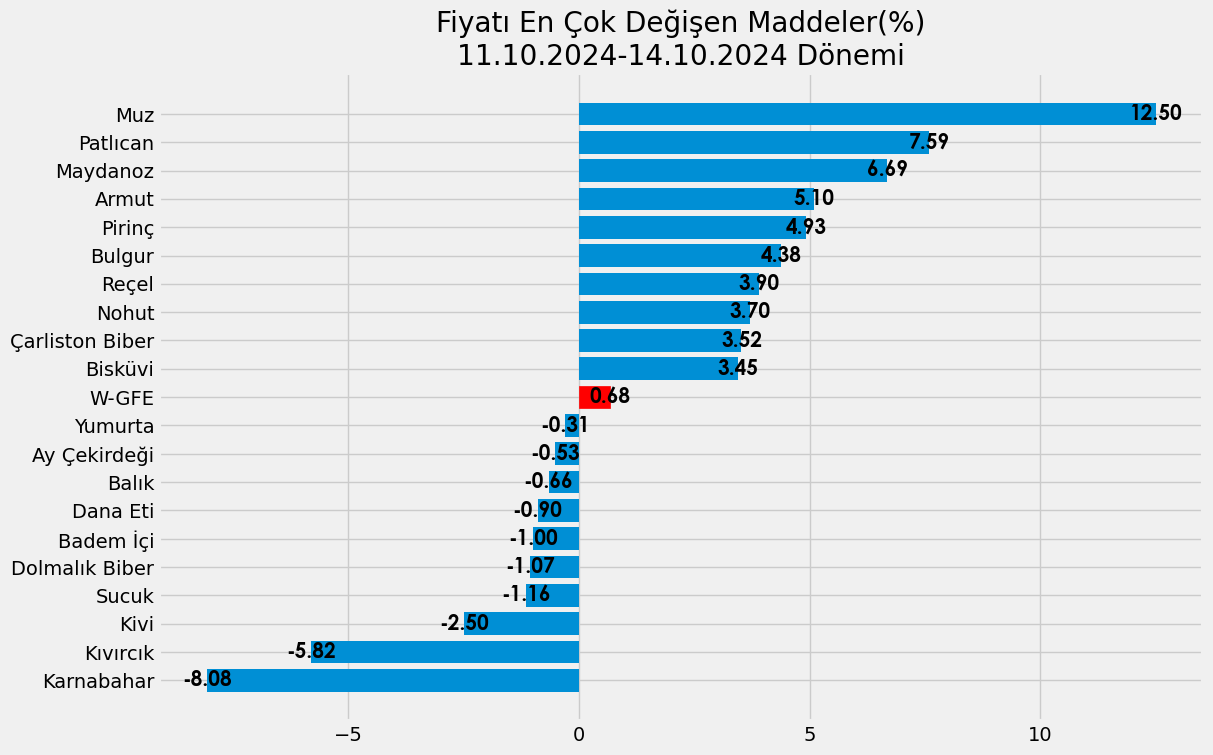

In [141]:
import matplotlib.pyplot as plt
veri=pd.concat([fark.sort_values().head(10),fark.sort_values().tail(10)],axis=0)
veri=pd.concat([veri,((gfe.iloc[-1]/gfe.iloc[0])-1)*100],axis=0)
veri=veri.sort_values()
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
first=gfe.index[0].strftime("%d.%m.%Y")
last=gfe.index[-1].strftime("%d.%m.%Y")
plt.title(f"Fiyatı En Çok Değişen Maddeler(%)\n{first}-{last} Dönemi")
bars=plt.barh(y=veri.index,width=veri.values)
for bar, label in zip(bars, veri.index):
    if label == "W-GFE":
        bar.set_color('red')
for bar in bars:
    plt.text(
        bar.get_width(),        # X coordinate (width of the bar)
        bar.get_y() + bar.get_height() / 2,  # Y coordinate (center of the bar)
        f'{bar.get_width():.2f}',  # Text label (bar width with 2 decimal points)
        va='center',            # Vertical alignment to center
        ha='center',              # Horizontal alignment to the left of the bar end
        fontsize=15,
        fontdict={'family': 'Century Gothic', 'weight': 'bold'}            # Font size for the labels
    )
plt.savefig(f"C:/Users/Bora/Documents/GitHub/streamlit-gfe/{bugün}_encokdegisim.png", bbox_inches='tight')
plt.show()


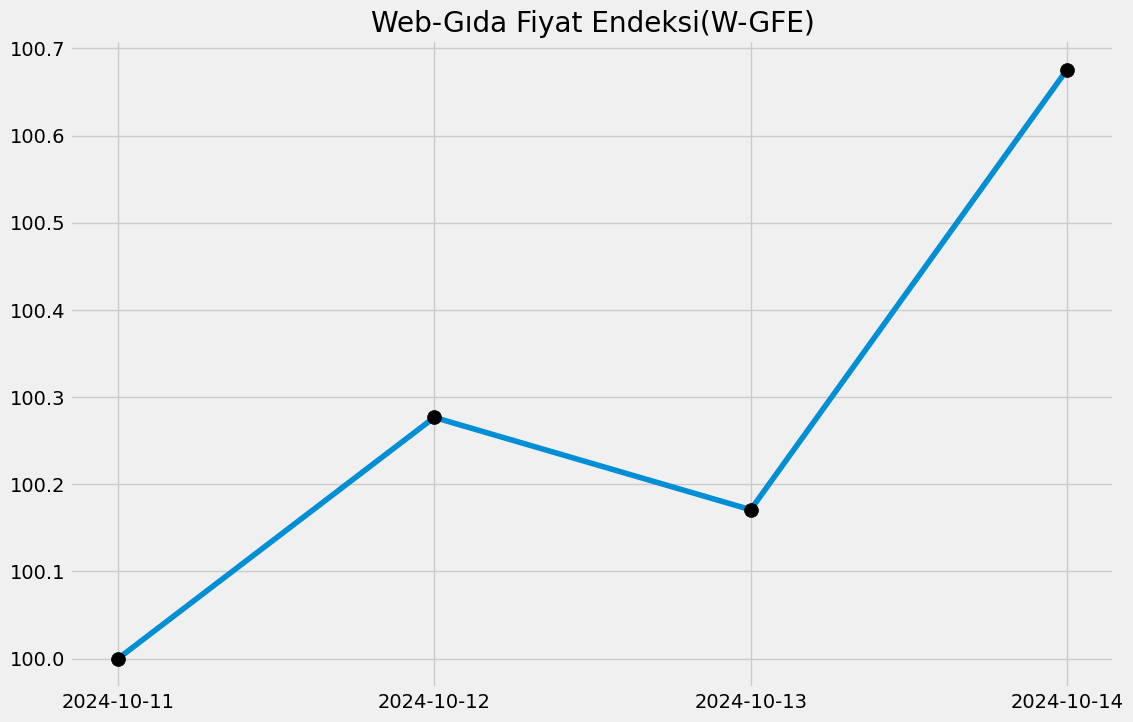

In [142]:
plt.figure(figsize=(12,8))
plt.title("Web-Gıda Fiyat Endeksi(W-GFE)")
plt.plot(gfe)
plt.scatter(x=gfe.index,y=gfe.values,s=100,color="black",zorder=3)
plt.xticks(gfe.index)
plt.savefig(f"C:/Users/Bora/Documents/GitHub/streamlit-gfe/{bugün}_gfe.png")

In [143]:
data1["Fark"]=((data1.iloc[:,-1]/data1.iloc[:,1])-1)*100

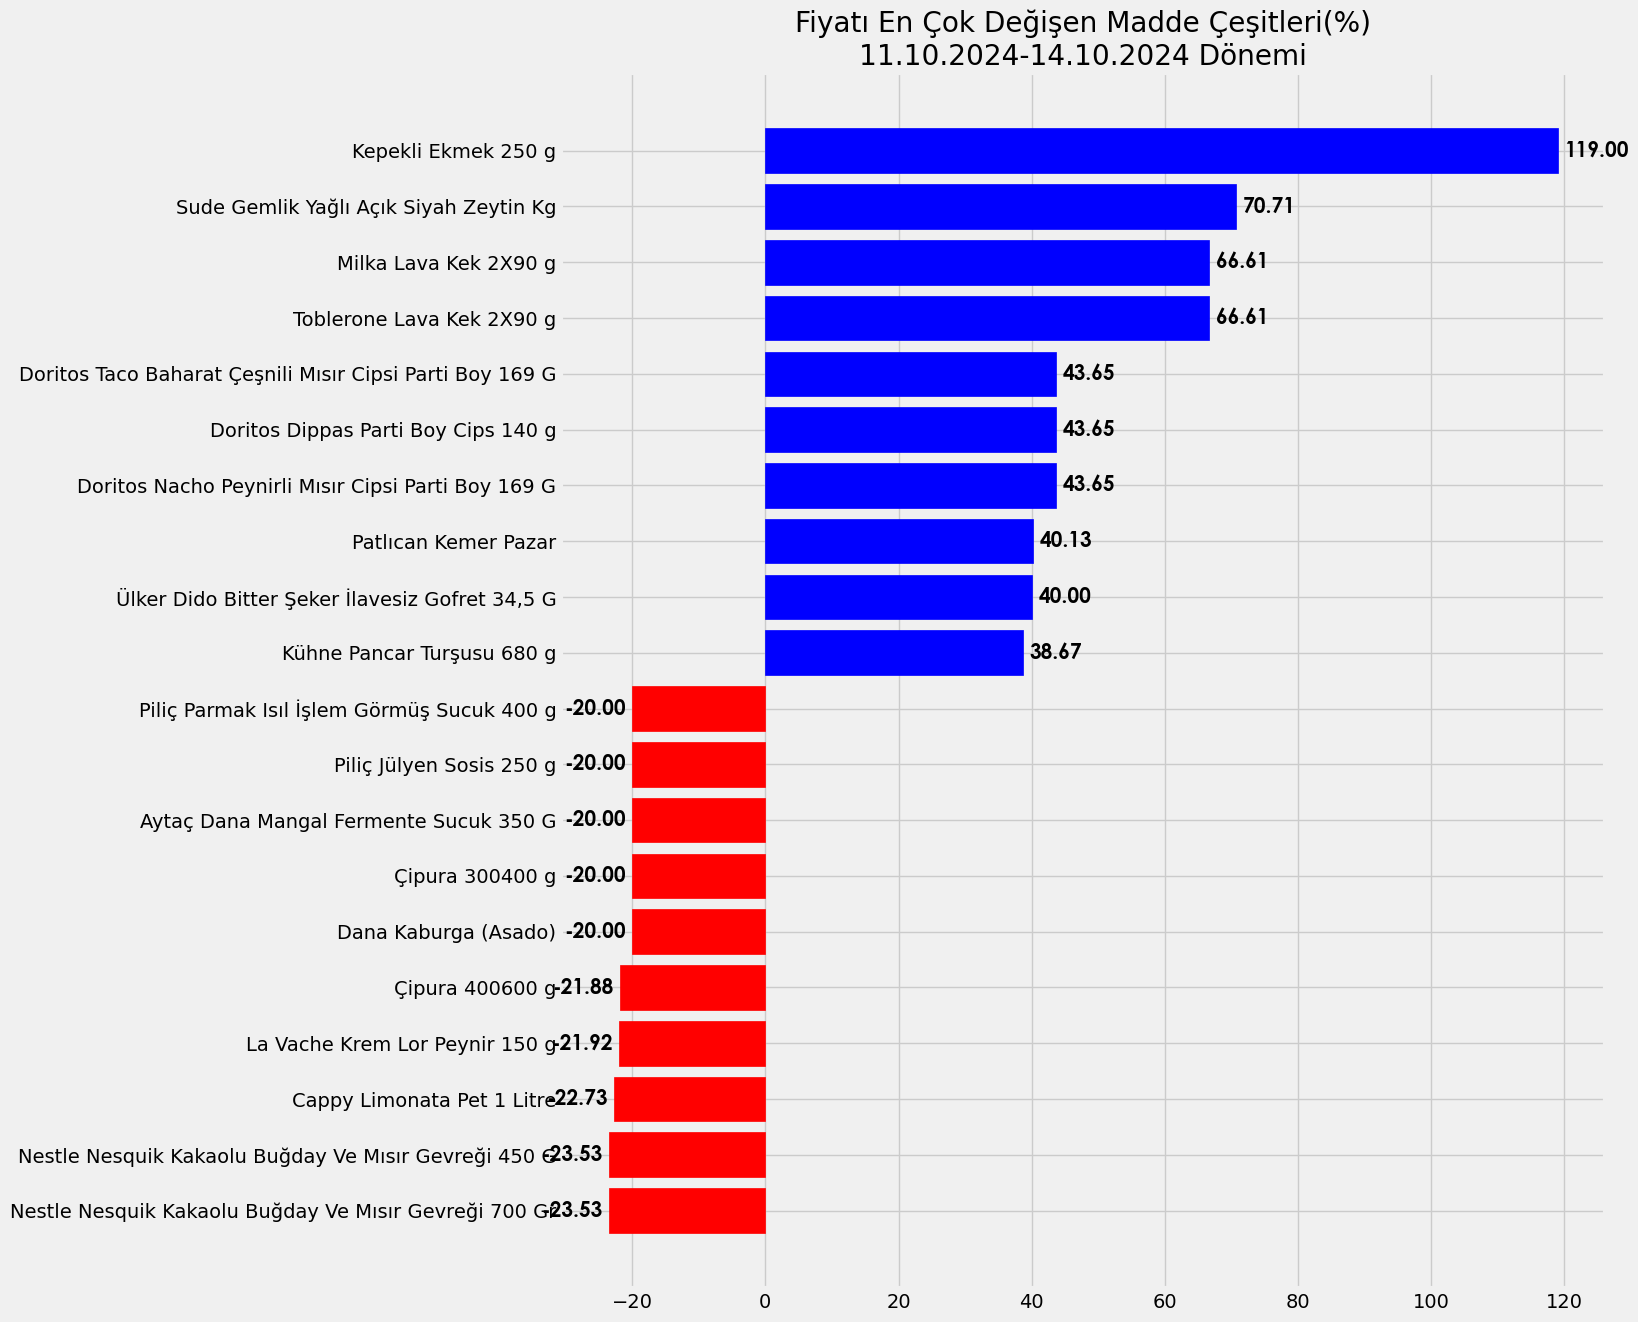

In [144]:
import matplotlib.pyplot as plt

# Verilerin hazırlanması (veri kısmı sizde olduğu gibi kalıyor)
veri = pd.concat([data1.sort_values(by="Fark").head(10), data1.sort_values(by="Fark").tail(10)], axis=0)
veri = veri.sort_values(by="Fark")

# Grafik ayarları
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 15))
first = gfe.index[0].strftime("%d.%m.%Y")
last = gfe.index[-1].strftime("%d.%m.%Y")
plt.title(f"Fiyatı En Çok Değişen Madde Çeşitleri(%)\n{first}-{last} Dönemi")

# Bar grafiği oluşturma
bars = plt.barh(y=veri["Ürün"], width=veri["Fark"])

# Her bir bar için renk ayarlama ve metin ekleme
for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('red')  # Negatif değerli barları kırmızı yap
        # Negatif barların metnini barın soluna yaz
        plt.text(
            bar.get_width() - 1,  # X coordinate (barın biraz soluna yazmak için)
            bar.get_y() + bar.get_height() / 2,  # Y coordinate (barın ortasına)
            f'{bar.get_width():.2f}',  # Text label (bar width with 2 decimal points)
            va='center',  # Vertical alignment to center
            ha='right',  # Horizontal alignment (sağa yaslı olacak şekilde)
            fontsize=15,
            fontdict={'family': 'Century Gothic', 'weight': 'bold'}  # Font size for the labels
        )
    else:
        bar.set_color('blue')  # Pozitif değerli barlar için mavi
        # Pozitif barların metnini barın sağına yaz
        plt.text(
            bar.get_width() + 1,  # X coordinate (barın biraz sağına yazmak için)
            bar.get_y() + bar.get_height() / 2,  # Y coordinate (barın ortasına)
            f'{bar.get_width():.2f}',  # Text label (bar width with 2 decimal points)
            va='center',  # Vertical alignment to center
            ha='left',  # Horizontal alignment (sola yaslı olacak şekilde)
            fontsize=15,
            fontdict={'family': 'Century Gothic', 'weight': 'bold'}  # Font size for the labels
        )

# Grafiği kaydetme
plt.savefig(f"C:/Users/Bora/Documents/GitHub/streamlit-gfe/{bugün}_encokdegisencesitler.png", bbox_inches='tight')
plt.show()


In [ ]:
def git_commit_and_push():
    try:
        # Git add komutu ile değişiklikleri ekliyoruz
        subprocess.run(["git", "add", "."], check=True)
        
        # Commit mesajı ekliyoruz
        commit_message = f"Price index update {datetime.now().isoformat()}"
        subprocess.run(["git", "commit", "-m", commit_message], check=True)
        
        # Değişiklikleri uzak depoya push ediyoruz
        subprocess.run(["git", "push", "origin", "main"], check=True)
        
        print("Git push işlemi başarılı.")
        
    except subprocess.CalledProcessError as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")